In [319]:
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
import re
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [320]:
# import functions from perturbseq codebase
import sys
sys.path.insert(0, '/data/rudensky/EYW/git_projects/SIG06/')
from perturbseq import *

# Import and Process Data

In [321]:
dataNorm = pd.read_csv("/data/rudensky/EYW/git_projects/SIG06/analysis_outs/counts_norm_DEseq2.csv")

In [322]:
deg = pd.read_csv("/data/rudensky/EYW/git_projects/SIG06/analysis_outs/res_viral_sig.csv")

In [323]:
meta = pd.read_csv("/data/rudensky/EYW/git_projects/SIG06/processing_outs/processed_metadata_SIG06.csv")

## get DEG values

In [324]:
degCounts = deg['treatment'].value_counts().reset_index()
degCounts.columns = ['treatment', 'count']
degCounts.rename(columns={'treatment':'ligand','count':'deg_counts'}, inplace=True)
degCounts['log10_deg_counts'] = np.log10(degCounts['deg_counts'])

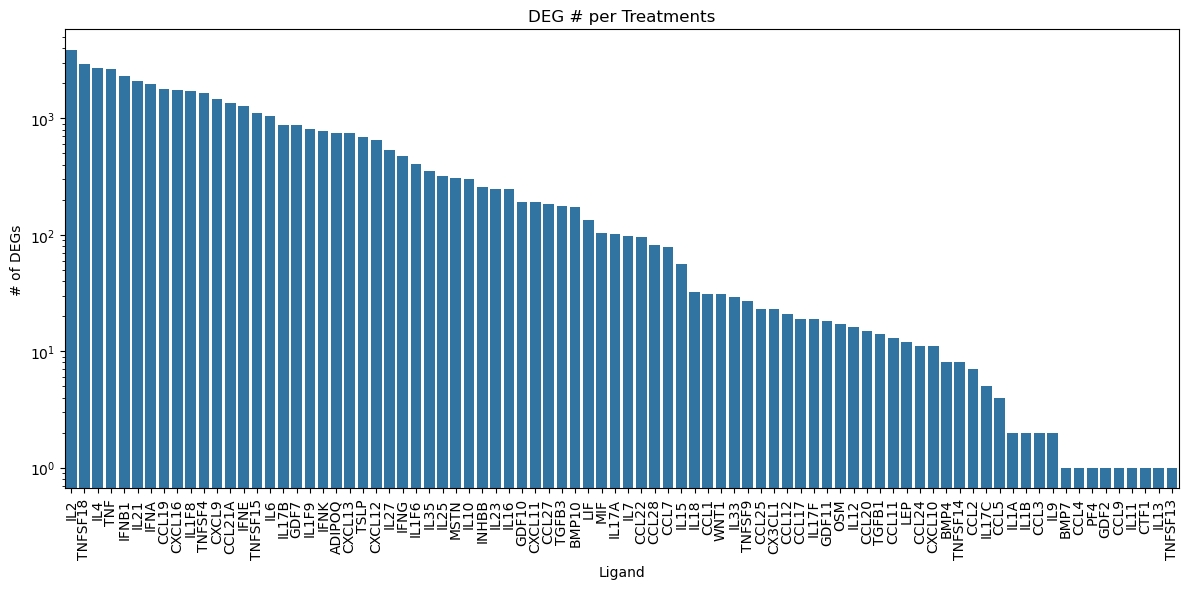

In [325]:
plt.figure(figsize=(12, 6))
sns.barplot(data=degCounts, x='ligand', y='deg_counts')
plt.yscale('log')
plt.title('DEG # per Treatments')
plt.xlabel('Ligand')
plt.ylabel('# of DEGs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Create Anndata Object

Next, I'll transfrom the counts matrix into ann anndata object.

In [326]:
# Extract gene IDs (rownames) and counts matrix
counts = dataNorm.set_index("gene")
counts.drop(columns=["ensembl_ID"], inplace=True)

# Parse the covariates from the column names
column_names = counts.columns
covariates = pd.DataFrame([name.split("_") for name in column_names],
                         index=column_names,
                         columns=["ligand", "group", "plate", "well_ID"])
# Join metadata to covariates
meta[["ligand", "group", "plate", "well_ID"]] = meta['sample_ID'].str.split('_', expand=True)
covariates = covariates.merge(meta, how="left",
                              on=["ligand", "group", "plate", "well_ID"])
covariates = covariates.merge(degCounts, how='left', on=['ligand'])

# Create an AnnData object
# Transpose because AnnData expects cells as rows and genes as columns
adata = ad.AnnData(X=counts.T.to_numpy())  

# Add parsed covariates to .obs and gene names to .var
adata.obs = covariates
adata.var["gene"] = counts.index

# create layer for normalized counts
adata.layers["norm_counts"] = adata.X.copy()

print(adata)

AnnData object with n_obs × n_vars = 330 × 15024
    obs: 'ligand', 'group', 'plate', 'well_ID', 'sample_ID', 'treatment', 'replicate', 'well', 'nFeature_RNA', 'nCount_RNA', 'deg_counts', 'log10_deg_counts'
    var: 'gene'
    layers: 'norm_counts'


### log transform norm counts

The counts provided are normalized by size factor, but are not log transformed. I will first log transform the data to make it compatible with downstream analysis. I'll also make a separate layer with the counts regressed by plate.

In [327]:
# log transform data
sc.pp.log1p(adata)
adata.layers["log1p_norm"] = adata.X.copy()

# filter lowly expressed genes
sc.pp.filter_genes(adata, min_cells=len(adata)*0.01) # filter for genes in >1% of cells

/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [328]:
# regress out effect of group
sc.pp.regress_out(adataHM,keys=["plate"])
adata.layers["log1p_norm_regressed"] = adata.X.copy()

### zscore norm counts
I will perform zscoring of the log1p normalized counts relative to controls for each group independently.

In [330]:
# zscore pearson residuals to biological groups
adata.X = adata.layers["log1p_norm"].copy()
normalized_matrix = normalize_to_control_residuals_adata(adata,
                                                         control_cells_query='ligand == "linker"',
                                                         groupby_column='group')
adata.layers["zscore_group"] = normalized_matrix.copy()

# zscore pearson residuals to biological groups
adata.X = adata.layers["log1p_norm_regressed"].copy()
normalized_matrix = normalize_to_control_residuals_adata(adata,
                                                         control_cells_query='ligand == "linker"',
                                                         groupby_column='group')
adata.layers["zscore_group_regressed"] = normalized_matrix.copy()

Multiple group detected. Processing each group separately.
Processing group group1
     Scaling matrix to control
     Done.
Processing group group2
     Scaling matrix to control
     Done.
Processing group group3
     Scaling matrix to control
     Done.
Merging submatrices...
Multiple group detected. Processing each group separately.
Processing group group1
     Scaling matrix to control
     Done.
Processing group group2
     Scaling matrix to control
     Done.
Processing group group3
     Scaling matrix to control
     Done.
Merging submatrices...


/data/rudensky/EYW/git_projects/SIG06/perturbseq/expression_normalization.py:92: RuntimeWarning: divide by zero encountered in divide
  m_out = (m - control_mean) / control_std
/data/rudensky/EYW/git_projects/SIG06/perturbseq/expression_normalization.py:92: RuntimeWarning: invalid value encountered in divide
  m_out = (m - control_mean) / control_std
/data/rudensky/EYW/git_projects/SIG06/perturbseq/expression_normalization.py:92: RuntimeWarning: divide by zero encountered in divide
  m_out = (m - control_mean) / control_std
/data/rudensky/EYW/git_projects/SIG06/perturbseq/expression_normalization.py:92: RuntimeWarning: invalid value encountered in divide
  m_out = (m - control_mean) / control_std


In [331]:
df = pd.DataFrame(adata.layers["log1p_norm"], index=(adata.obs["ligand"]+"_"+adata.obs["group"]), columns=adata.var["gene"])
df.to_csv('/data/rudensky/EYW/git_projects/SIG06/analysis_outs/norm_data_log1p_SIG06.csv')
df1 = pd.DataFrame(adata.layers["zscore_group"], index=(adata.obs["ligand"]+"_"+adata.obs["group"]), columns=adata.var["gene"])
df1.to_csv('/data/rudensky/EYW/git_projects/SIG06/analysis_outs/norm_data_zscore_group_SIG06.csv')
df3 = pd.DataFrame(adata.layers["log1p_norm_regressed"], index=(adata.obs["ligand"]+"_"+adata.obs["group"]), columns=adata.var["gene"])
df3.to_csv('/data/rudensky/EYW/git_projects/SIG06/analysis_outs/norm_data_log1p_regressed_SIG06.csv')
df4 = pd.DataFrame(adata.layers["zscore_group_regressed"], index=(adata.obs["ligand"]+"_"+adata.obs["group"]), columns=adata.var["gene"])
df4.to_csv('/data/rudensky/EYW/git_projects/SIG06/analysis_outs/norm_data_zscore_group_regressed_SIG06.csv')

# Helper Functions
Here I'm just adding a few helper functions to make plotting the heatmaps easier

In [32]:
def mean_aggr_adata(adata, aggregate_columns=['ligand_call_oBC_CR']):
    """
    Aggregates an AnnData object by calculating mean expressions for groups defined by `aggregate_columns`.

    Parameters:
    -----------
    adata : AnnData
        Input AnnData object.
    aggregate_columns : list
        List of columns in `adata.obs` used to group and aggregate the data.

    Returns:
    --------
    AnnData
        A new AnnData object with aggregated (mean) expressions and updated `obs` and `var`.
    """
    # Create a DataFrame from the AnnData object
    df = pd.DataFrame(adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X,
                      index=adata.obs.index, 
                      columns=adata.var_names)
    
    # Add aggregate columns to the DataFrame
    for col in aggregate_columns:
        df[col] = adata.obs[col]
    
    # Group by the specified columns and compute mean expression
    mean_aggregated = df.groupby(aggregate_columns, observed=True).mean()
    
    # Extract the index of the grouped DataFrame (group identifiers)
    new_obs = mean_aggregated.index.to_frame(index=False)  # Convert MultiIndex to DataFrame
    
    # Convert the mean values back to a matrix
    new_X = mean_aggregated.values
    
    # Create a new AnnData object
    aggregated_adata = ad.AnnData(
        X=new_X,
        obs=new_obs,
        var=adata.var.copy()  # Retain the original gene information
    )
    
    return aggregated_adata

In [33]:
def generate_corr(adata, aggregate_columns=['ligand_call_oBC_CR']):
   # Create a DataFrame from the AnnData object
    df = pd.DataFrame(adata.X.toarray(), index=adata.obs.index, columns=adata.var_names)
    df[aggregate_columns] = adata.obs[aggregate_columns]
    
    # Calculate mean expression grouped by `ligand_call_oBC_CR`
    mean_aggregated = df.groupby(aggregate_columns,observed=True).mean()
    # Calculate the correlation matrix
    correlation_matrix = mean_aggregated.T.corr()
    
    return correlation_matrix

In [35]:
import re
# helper function to remove genes based on regex matching from HVG column
def update_highly_variable_genes(adata, regex_pattern, variable_gene_column='highly_variable'):
    """
    Filters and updates the 'highly_variable' column in an AnnData object by removing genes matching a regex pattern.

    Parameters:
    - adata (AnnData): The AnnData object containing the data.
    - regex_pattern (str): The regex pattern to identify genes to be removed from 'highly_variable'.
    - variable_gene_column (str): The column in `adata.var` indicating highly variable genes.

    Returns:
    - adata (AnnData): The modified AnnData object with the updated 'highly_variable' column.
    - matching_genes (list): A list of genes that matched the regex pattern.
    """
    # Ensure the variable_gene_column exists
    if variable_gene_column not in adata.var:
        raise ValueError(f"'{variable_gene_column}' column not found in adata.var")

    # Extract the list of highly variable genes
    highly_variable_genes = adata.var_names[adata.var[variable_gene_column]]

    # Compile the regex pattern
    regex = re.compile(regex_pattern)

    # Find genes matching the regex pattern
    matching_genes = [gene for gene in highly_variable_genes if regex.match(gene)]

    # Update the 'highly_variable' column: set matching genes to False
    adata.var[variable_gene_column] = adata.var_names.isin(highly_variable_genes)
    adata.var.loc[adata.var_names.isin(matching_genes), variable_gene_column] = False

    # Return the updated AnnData object and the list of matching genes
    return adata, matching_genes

# Correlation Heatmaps Full

I will make ligand-level pearson correlation heatmaps using mean-averaged values across replicates.

## Correlation Heatmaps Full

First, I will make heatmaps using all ligands in the dataset. With both log1p UMI normalized counts and z-scored (to control) counts.

### UMI Norm HM

In [357]:
# make copy of data
adataHM = adata.copy()

# remove recomb and none ligands
mask = ~adataHM.obs['ligand'].str.contains('recomb|none', case=False, na=False)
adataHM = adataHM[mask].copy()

# change layers
adataHM.X = adataHM.layers['log1p_norm_regressed'].copy()

In [358]:
# find HVGs
sc.pp.highly_variable_genes(adataHM, n_top_genes=3000)
# Remove TCR and IG genes
adataHM, matching_genes = update_highly_variable_genes(adataHM, r"^Tra[vj]|^Trb[vdj]|^Igk[vc]|^Igl[vc]|^Ighv")
print(f"Number of highly variable genes remaining: {adataHM.var['highly_variable'].sum()}")

Number of highly variable genes remaining: 3000


In [359]:
# make correlation matrix and ligand annotations
adataHM_hv = adataHM[:, adataHM.var['highly_variable']]
correlation_matrix = generate_corr(adataHM_hv, aggregate_columns=['ligand'])

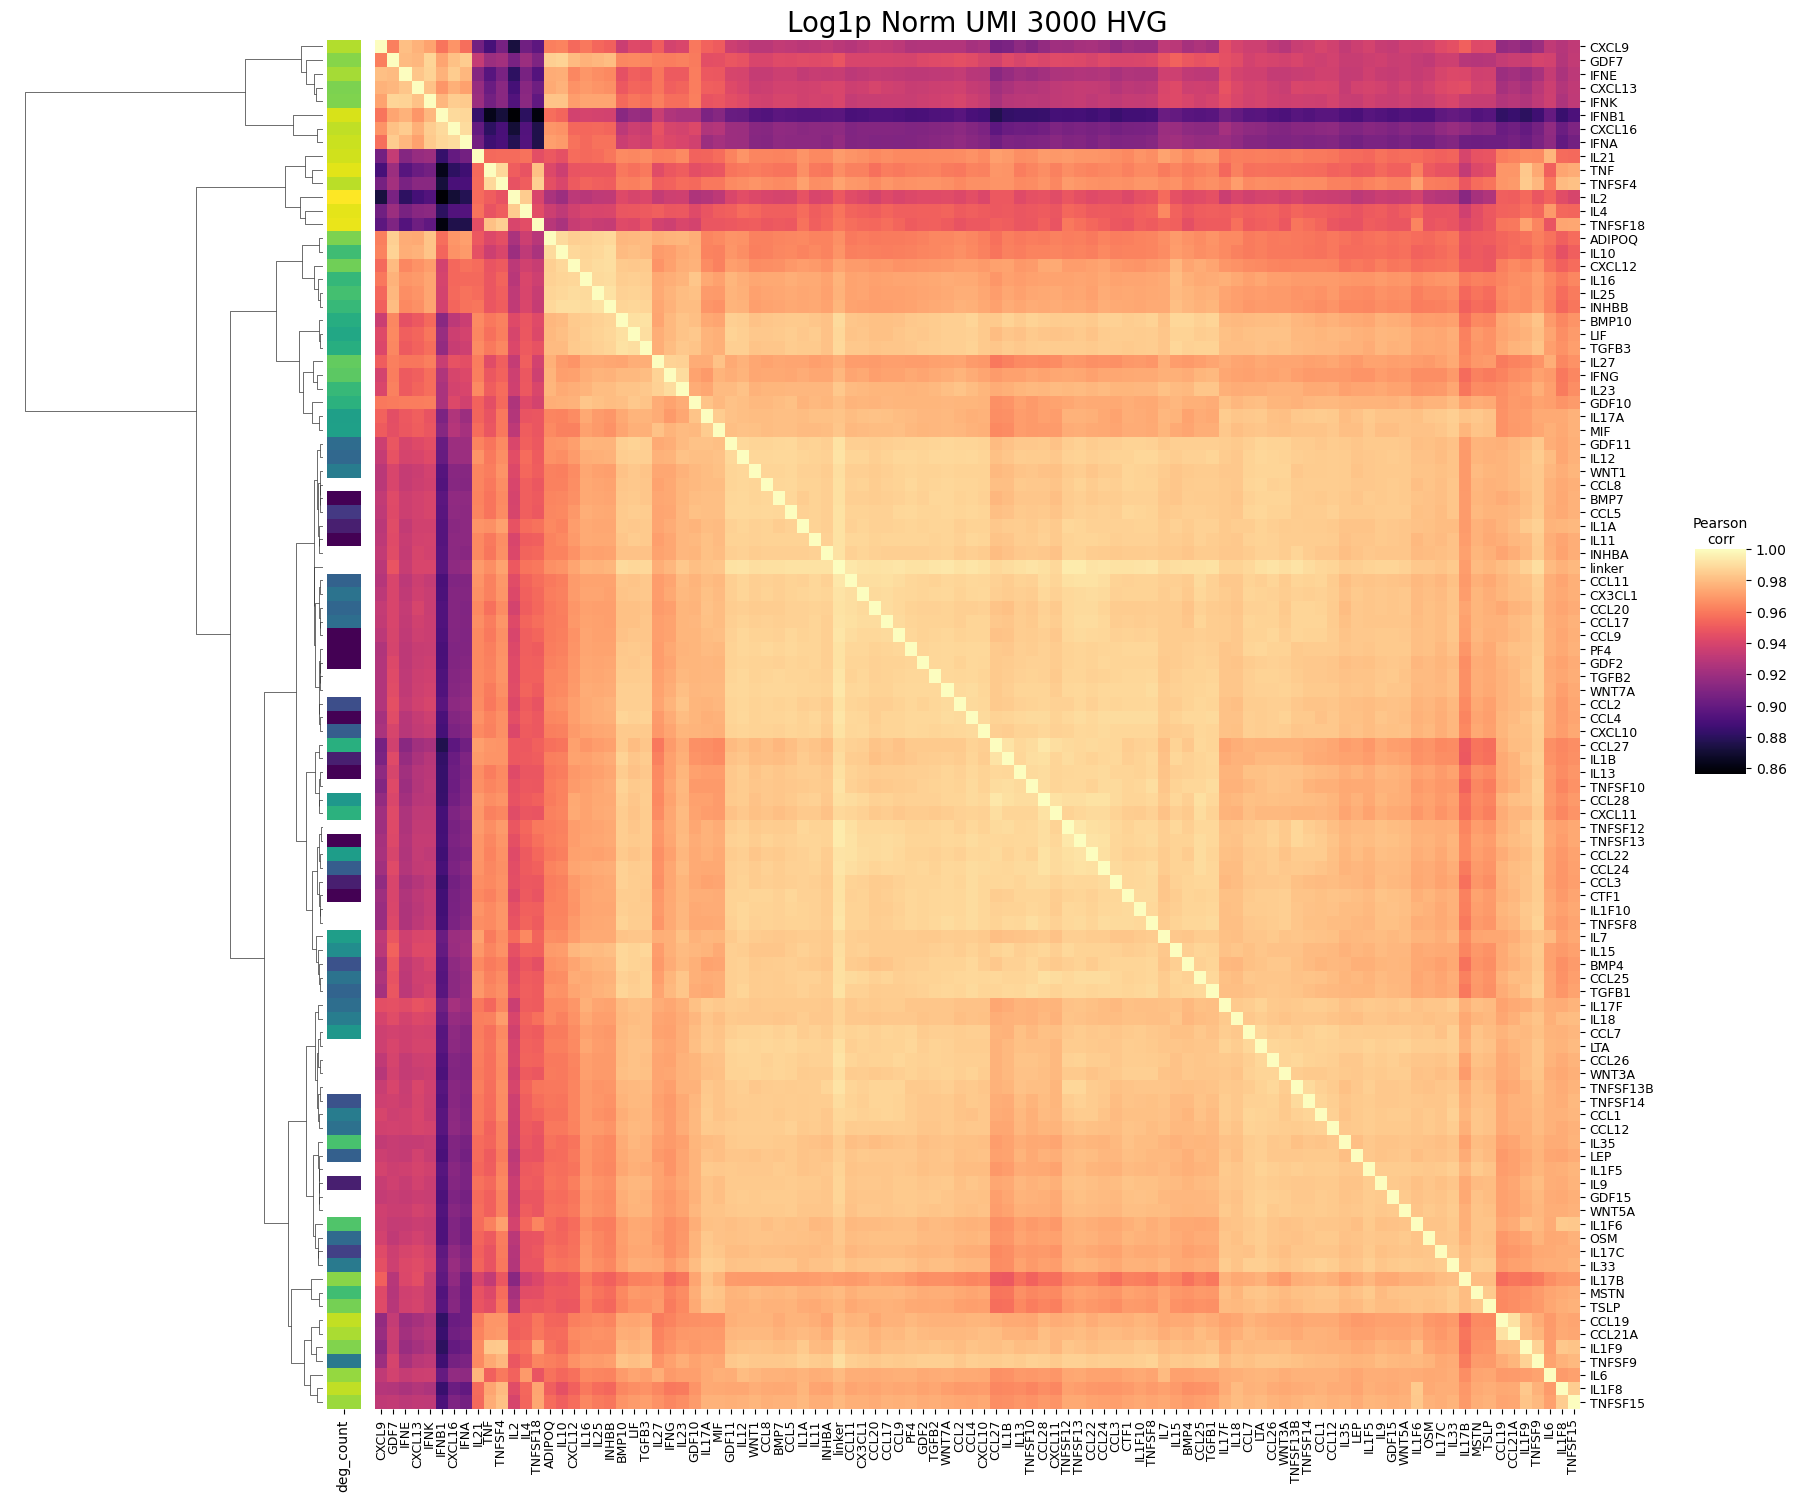

In [360]:
degCountsHigh = degCounts.copy()
degCountsHigh['deg_count'] = (
    degCountsHigh['log10_deg_counts'] - degCountsHigh['log10_deg_counts'].min()
) / (degCountsHigh['log10_deg_counts'].max() - degCountsHigh['log10_deg_counts'].min())
# Generate a colormap for the annotation bar
colors = sns.color_palette("viridis", as_cmap=True)
# Map treatment to count-based color
row_colors = degCountsHigh.set_index('ligand')['deg_count'].map(colors)

# Plot the heatmap using seaborn
g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='magma',
                   method='ward',
                   vmax=1, 
                   dendrogram_ratio=(.2, 0),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={
                       'orientation': 'vertical',  # Vertical colorbar
                       'shrink': 0.5,  # Shrink the colorbar size
                   },
                   row_colors=row_colors,
                   figsize=(17, 15))

# Move the row_colors bar to the left
row_colors_ax = g.ax_row_colors
row_colors_position = row_colors_ax.get_position()
row_colors_ax.set_position([0.195, row_colors_position.y0, 0.02, row_colors_position.height])  # [x, y, width, height

# Adjust the colorbar and tick labels
g.cax.set_position([1, 0.5, .03, .15])  # [x, y, width, height] for the colorbar position
# Make the colorbar label horizontal
g.cax.set_xlabel('Pearson\ncorr', fontsize=10)  # Set horizontal label
g.cax.xaxis.set_label_position('top')  # Position the label below the colorbar

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
g.ax_heatmap.set_title('Log1p Norm UMI 3000 HVG', fontsize=20)

plt.show()

In this heatmap, the blanks in the deg_count section are those that have 0 degs.

### Zscore HM

In [361]:
# process data
adataHM.X = adataHM.layers['zscore_group_regressed'].copy()

# make correlation matrix and ligand annotations
adataHM_hv = adataHM[:, adataHM.var['highly_variable']]
correlation_matrix = generate_corr(adataHM_hv, aggregate_columns=['ligand'])

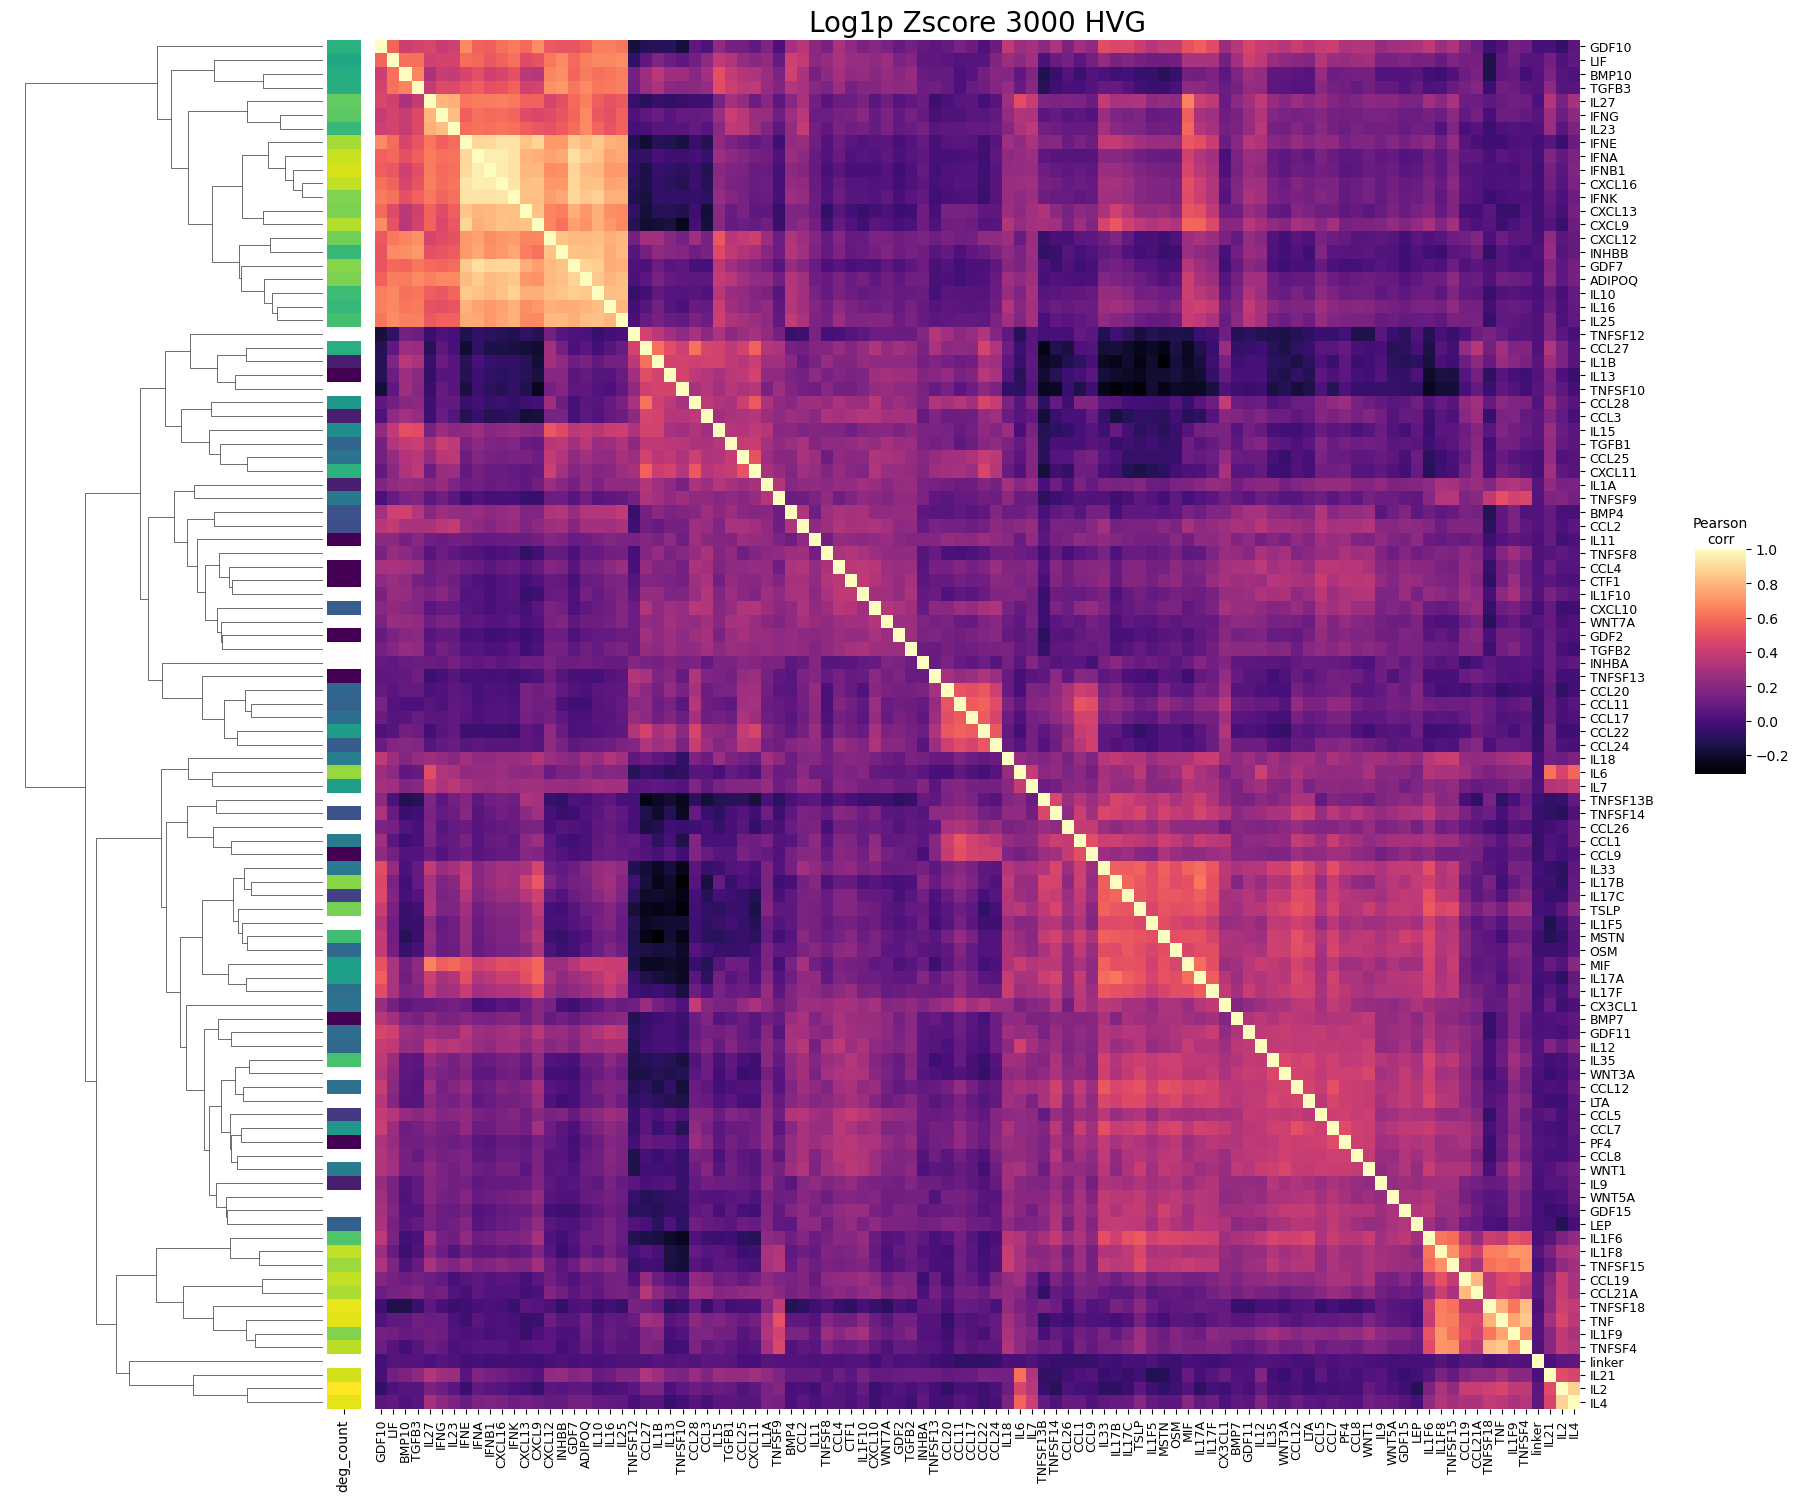

In [362]:
degCountsHigh = degCounts.copy()
degCountsHigh['deg_count'] = (
    degCountsHigh['log10_deg_counts'] - degCountsHigh['log10_deg_counts'].min()
) / (degCountsHigh['log10_deg_counts'].max() - degCountsHigh['log10_deg_counts'].min())
# Generate a colormap for the annotation bar
colors = sns.color_palette("viridis", as_cmap=True)
# Map treatment to count-based color
row_colors = degCountsHigh.set_index('ligand')['deg_count'].map(colors)

# Plot the heatmap using seaborn
g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='magma',
                   method='average',
                   vmax=1, 
                   dendrogram_ratio=(.2, 0),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={
                       'orientation': 'vertical',  # Vertical colorbar
                       'shrink': 0.5,  # Shrink the colorbar size
                   },
                   row_colors=row_colors,
                   figsize=(17, 15))

# Move the row_colors bar to the left
row_colors_ax = g.ax_row_colors
row_colors_position = row_colors_ax.get_position()
row_colors_ax.set_position([0.195, row_colors_position.y0, 0.02, row_colors_position.height])  # [x, y, width, height

# Adjust the colorbar and tick labels
g.cax.set_position([1, 0.5, .03, .15])  # [x, y, width, height] for the colorbar position
# Make the colorbar label horizontal
g.cax.set_xlabel('Pearson\ncorr', fontsize=10)  # Set horizontal label
g.cax.xaxis.set_label_position('top')  # Position the label below the colorbar

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
g.ax_heatmap.set_title('Log1p Zscore 3000 HVG', fontsize=20)

plt.show()

## Correlation Heatmaps high DEG ligands only

To make things cleaner, I'm going to focus on ligands with high numbers of DEGs. This is kind of an arbitrary cutoff and probably is dependent on sequencing depth too (e.g. if I sequence deeper will need to adjust)

### UMI Norm HM

In [349]:
# make copy of data
adataHM = adata.copy()

# subset deg
degCountsHigh = degCounts[degCounts["deg_counts"] > 10]

# remove recomb and none ligands
mask1 = (adataHM.obs['ligand'].isin(degCountsHigh["ligand"]))|(adataHM.obs['ligand']=="linker")
mask2 = ~adataHM.obs['ligand'].str.contains('recomb|none', case=False, na=False)
adataHM = adataHM[mask1 & mask2].copy()

# change layers
adataHM.X = adataHM.layers['log1p_norm_regressed'].copy()

In [350]:
# find HVGs
sc.pp.highly_variable_genes(adataHM, n_top_genes=3000)
# Remove TCR and IG genes
adataHM, matching_genes = update_highly_variable_genes(adataHM, r"^Tra[vj]|^Trb[vdj]|^Igk[vc]|^Igl[vc]|^Ighv")
print(f"Number of highly variable genes remaining: {adataHM.var['highly_variable'].sum()}")

Number of highly variable genes remaining: 3000


In [351]:
# make correlation matrix and ligand annotations
adataHM_hv = adataHM[:, adataHM.var['highly_variable']]
correlation_matrix = generate_corr(adataHM_hv, aggregate_columns=['ligand'])

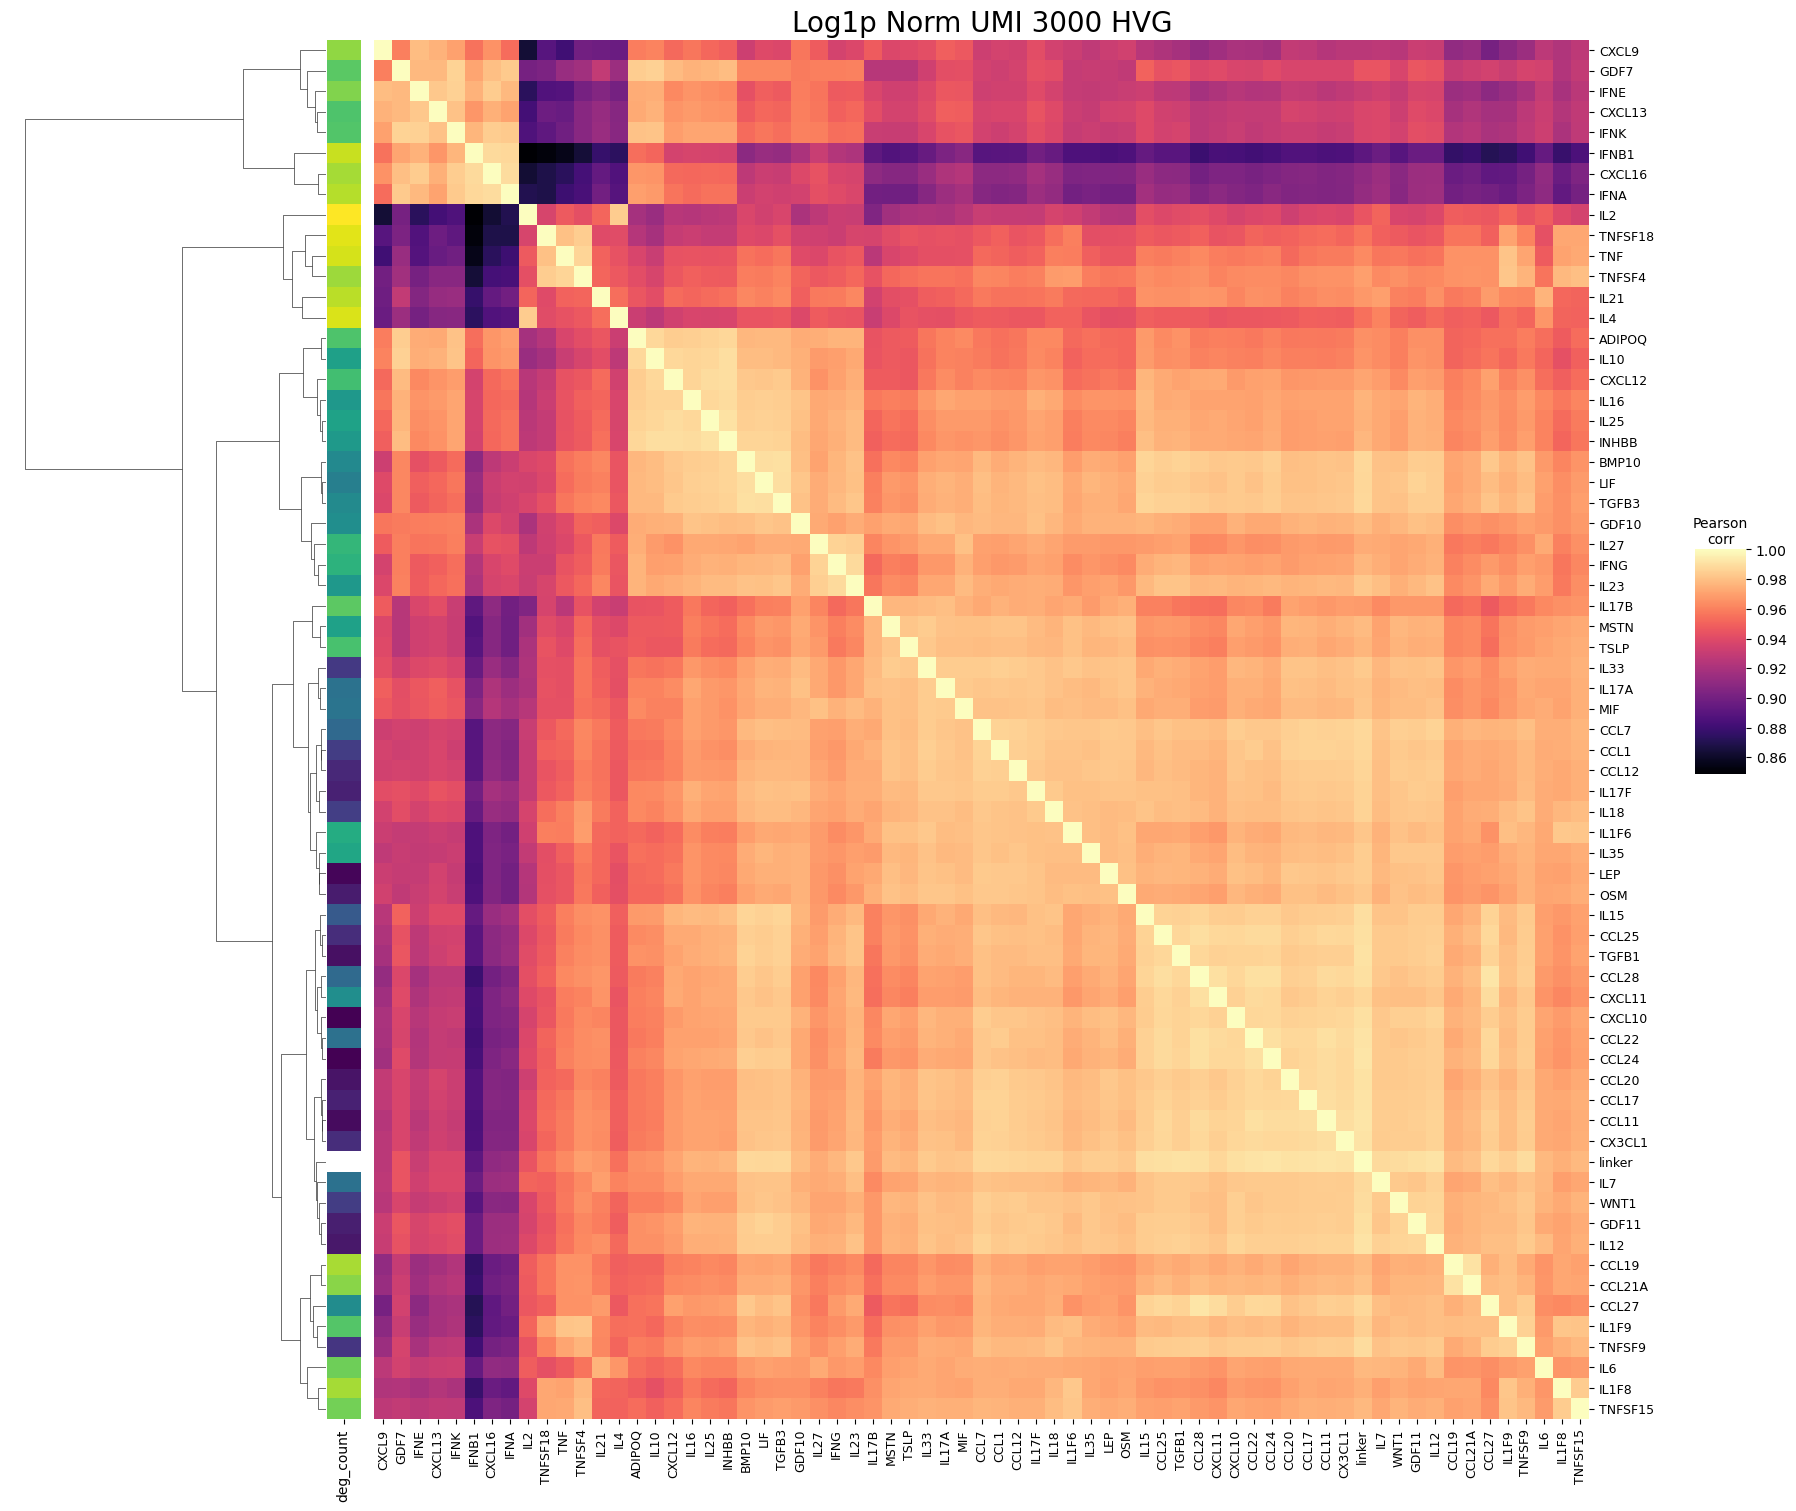

In [352]:
degCountsHigh = degCountsHigh.copy()
degCountsHigh['deg_count'] = (
    degCountsHigh['log10_deg_counts'] - degCountsHigh['log10_deg_counts'].min()
) / (degCountsHigh['log10_deg_counts'].max() - degCountsHigh['log10_deg_counts'].min())
# Generate a colormap for the annotation bar
colors = sns.color_palette("viridis", as_cmap=True)
# Map treatment to count-based color
row_colors = degCountsHigh.set_index('ligand')['deg_count'].map(colors)

# Plot the heatmap using seaborn
g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='magma',
                   method='ward',
                   vmax=1, 
                   dendrogram_ratio=(.2, 0),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={
                       'orientation': 'vertical',  # Vertical colorbar
                       'shrink': 0.5,  # Shrink the colorbar size
                   },
                   row_colors=row_colors,
                   figsize=(17, 15))

# Move the row_colors bar to the left
row_colors_ax = g.ax_row_colors
row_colors_position = row_colors_ax.get_position()
row_colors_ax.set_position([0.195, row_colors_position.y0, 0.02, row_colors_position.height])  # [x, y, width, height

# Adjust the colorbar and tick labels
g.cax.set_position([1, 0.5, .03, .15])  # [x, y, width, height] for the colorbar position
# Make the colorbar label horizontal
g.cax.set_xlabel('Pearson\ncorr', fontsize=10)  # Set horizontal label
g.cax.xaxis.set_label_position('top')  # Position the label below the colorbar

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
g.ax_heatmap.set_title('Log1p Norm UMI 3000 HVG', fontsize=20)

plt.show()

### Zscore HM

In [353]:
# process data
adataHM.X = adataHM.layers['zscore_group_regressed'].copy()

# make correlation matrix and ligand annotations
adataHM_hv = adataHM[:, adataHM.var['highly_variable']]
correlation_matrix = generate_corr(adataHM_hv, aggregate_columns=['ligand'])

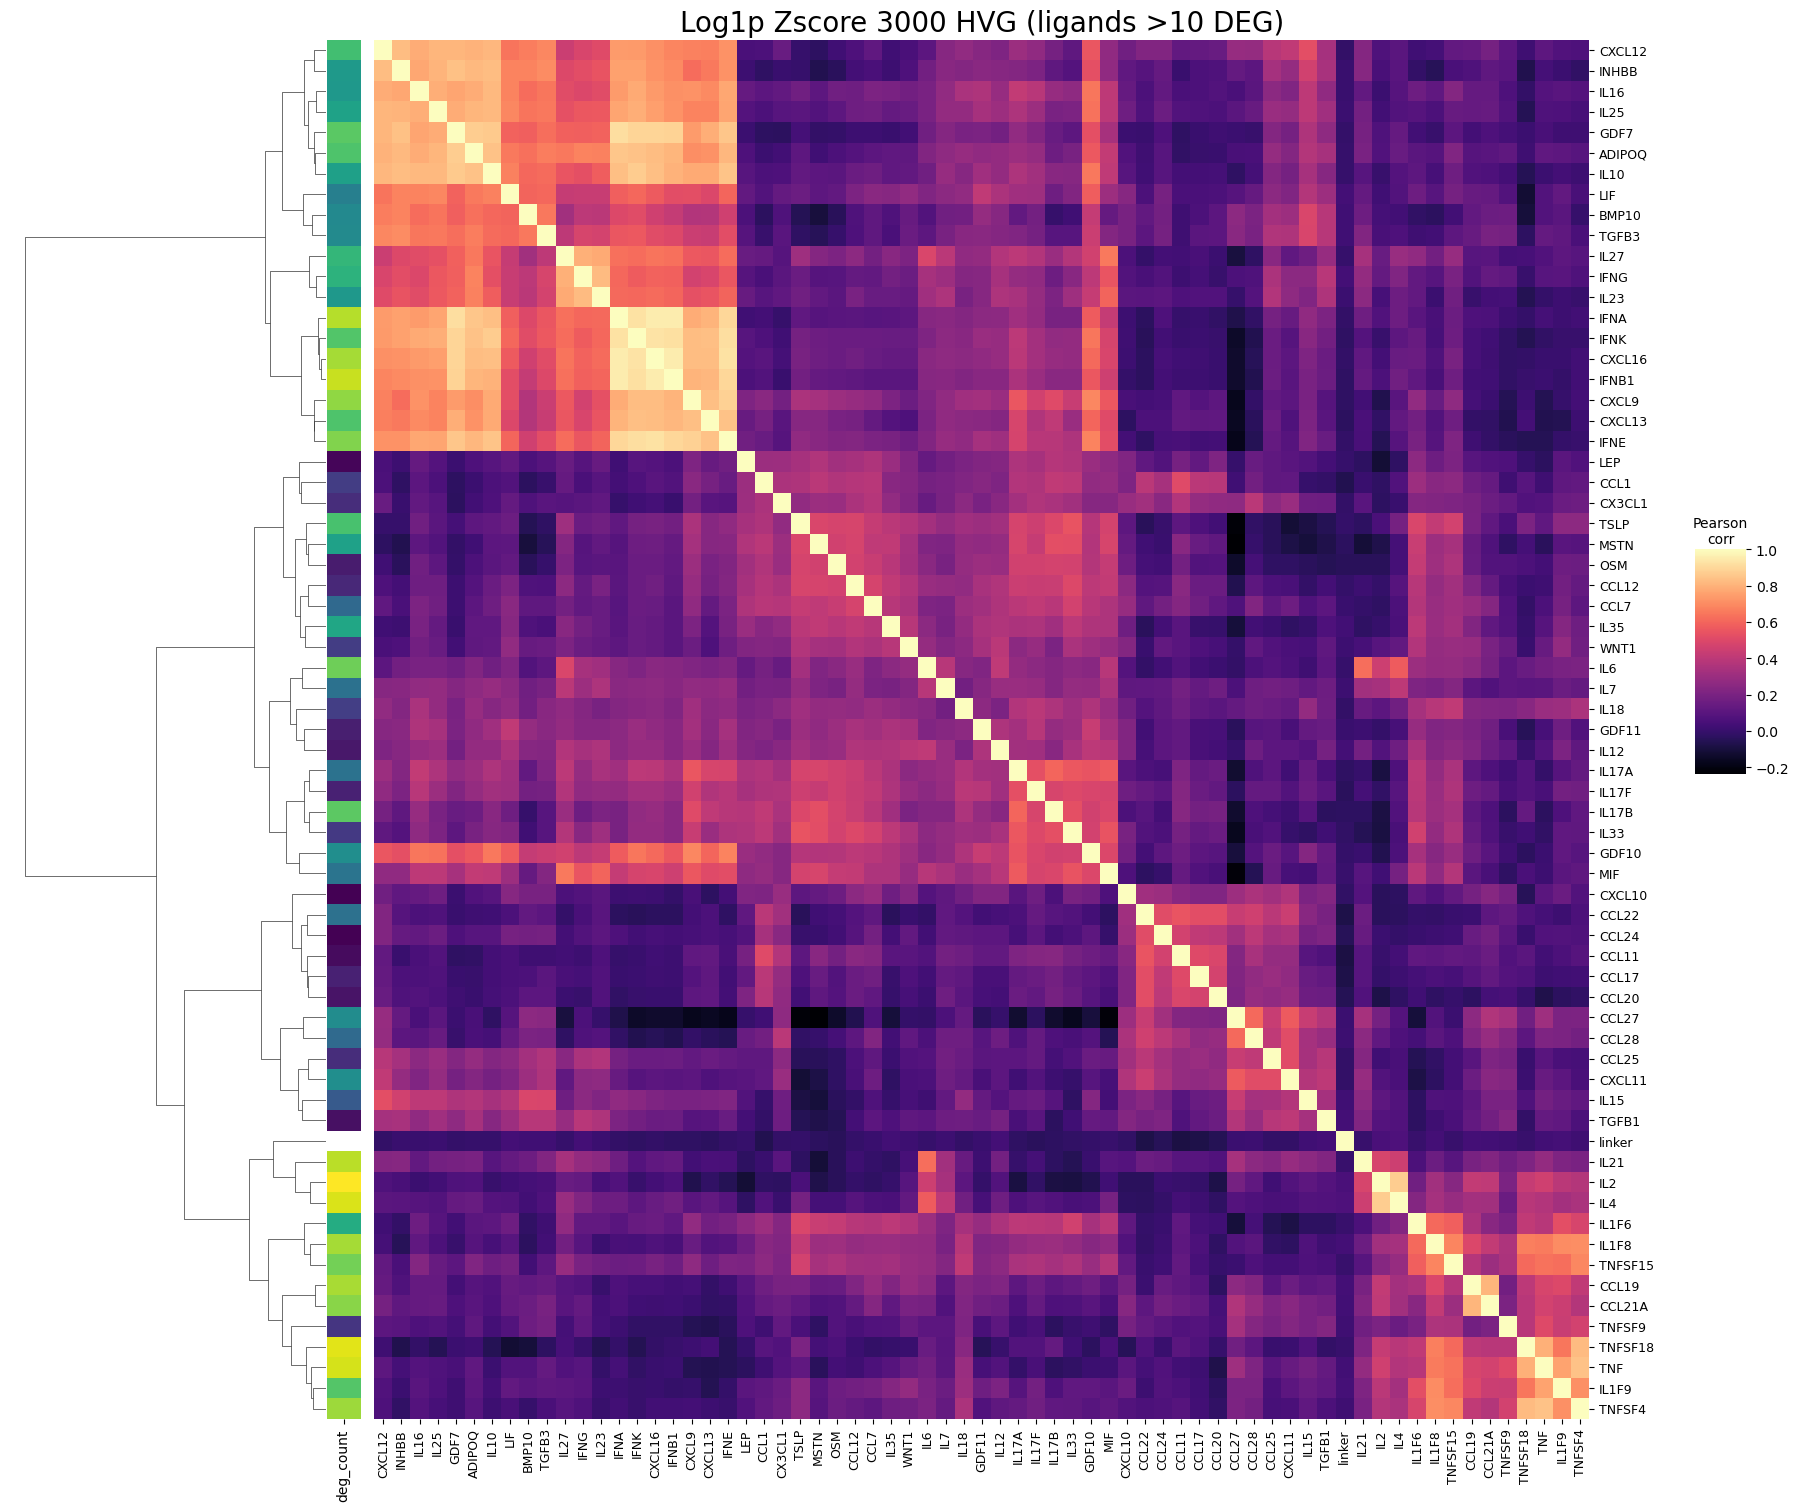

In [354]:
degCountsHigh = degCountsHigh.copy()
degCountsHigh['deg_count'] = (
    degCountsHigh['log10_deg_counts'] - degCountsHigh['log10_deg_counts'].min()
) / (degCountsHigh['log10_deg_counts'].max() - degCountsHigh['log10_deg_counts'].min())
# Generate a colormap for the annotation bar
colors = sns.color_palette("viridis", as_cmap=True)
# Map treatment to count-based color
row_colors = degCountsHigh.set_index('ligand')['deg_count'].map(colors)

# Plot the heatmap using seaborn
g = sns.clustermap(correlation_matrix, 
                   annot=False, 
                   cmap='magma',
                   method='ward',
                   vmax=1, 
                   dendrogram_ratio=(.2, 0),  # Adjusts the width of the dendrogram
                   xticklabels=True,  # Ensures all x-axis labels are shown
                   yticklabels=True,  # Ensures all y-axis labels are shown
                   cbar_kws={
                       'orientation': 'vertical',  # Vertical colorbar
                       'shrink': 0.5,  # Shrink the colorbar size
                   },
                   row_colors=row_colors,
                   figsize=(17, 15))

# Move the row_colors bar to the left
row_colors_ax = g.ax_row_colors
row_colors_position = row_colors_ax.get_position()
row_colors_ax.set_position([0.195, row_colors_position.y0, 0.02, row_colors_position.height])  # [x, y, width, height

# Adjust the colorbar and tick labels
g.cax.set_position([1, 0.5, .03, .15])  # [x, y, width, height] for the colorbar position
# Make the colorbar label horizontal
g.cax.set_xlabel('Pearson\ncorr', fontsize=10)  # Set horizontal label
g.cax.xaxis.set_label_position('top')  # Position the label below the colorbar

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
g.ax_heatmap.set_title('Log1p Zscore 3000 HVG (ligands >10 DEG)', fontsize=20)

plt.show()

# MDE ligand + sample level all ligands

Here, I will use pymde to perform minimal distortion embedding. This is inspired by the usage of MDE in visualizing perturbations in the Weissman genome-wide dataset (https://pubmed.ncbi.nlm.nih.gov/35688146/). I will essentially be copying their approach, although because this data is much lower dimension, I will try using spectral embedding and just using the zscore counts directly.

The key thing to note in their approach is that by z-scoring each cell prior to using MDE. This allows for **MDE to minimize correlation distance rather than euclidean distance**.

In [458]:
import pymde
from scipy.stats import zscore
from sklearn.manifold import SpectralEmbedding

In [459]:
# make copy of data
adataHM = adata.copy()
# remove recomb and none ligands
mask2 = ~adataHM.obs['ligand'].str.contains('recomb|none', case=False, na=False)
adataHM = adataHM[mask2].copy()
# change layers
adataHM.X = adataHM.layers['log1p_norm_regressed'].copy()
# find HVGs
sc.pp.highly_variable_genes(adataHM, n_top_genes=3000)
# Remove TCR and IG genes
adataHM, matching_genes = update_highly_variable_genes(adataHM, r"^Tra[vj]|^Trb[vdj]|^Igk[vc]|^Igl[vc]|^Ighv")
print(f"Number of highly variable genes remaining: {adataHM.var['highly_variable'].sum()}")

Number of highly variable genes remaining: 3000


In [460]:
# change layers
adataHM.X = adataHM.layers['log1p_norm_regressed'].copy()
# subset adata only on HVGs
adata_hv = adataHM[:, adataHM.var['highly_variable']]
# return adata with mean aggregated values
adata_mean_LS = mean_aggr_adata(adata_hv, aggregate_columns=['ligand',"group","plate","nCount_RNA","nFeature_RNA"])
# edit metadata
adata_mean_LS.obs["log_nCount_RNA"] = np.log(adata_mean_LS.obs["nCount_RNA"])
adata_mean_LS.obs["log_nFeature_RNA"] = np.log(adata_mean_LS.obs["nFeature_RNA"])
adata_mean_LS.obs = adata_mean_LS.obs.merge(degCounts,how="left",on=["ligand"])
adata_mean_LS.obs["ligand"] = adata_mean_LS.obs["ligand"].astype("category")
# fill NaN values in numeric columns only
numeric_columns = ['deg_counts', 'log10_deg_counts']  # specify your numeric columns
for col in numeric_columns:
    adata_mean_LS.obs[col] = adata_mean_LS.obs[col].fillna(0)

# perform z-scoring by row (by cell)
zscore_counts = zscore(adata_mean_LS.X, axis = 1)

/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## MDE with counts data

In [461]:
# Use pymde for high-dimensional embedding
mde = pymde.preserve_neighbors(
    zscore_counts,
    embedding_dim=2,
    repulsive_fraction=2,
)
embedding = mde.embed()

# Add the embedding to the AnnData object
adata_mean_LS.obsm["mde"] = embedding.numpy()

## MDE with counts data and spectral embedding

In [462]:
# Spectral embedding initialization using sklearn
spectral_embedder = SpectralEmbedding(
    n_components=30,
    affinity='nearest_neighbors',
    n_jobs=-1,
)
spectral_embedding = spectral_embedder.fit_transform(zscore_counts)

# Use pymde for high-dimensional embedding
mde = pymde.preserve_neighbors(
    spectral_embedding,
    embedding_dim=2,  # Dimensionality of the pymde embedding
    repulsive_fraction=5,  # Adjust repulsion strength
    verbose=True  # Print progress
)
embedding = mde.embed()

# Add the embedding to the AnnData object
adata_mean_LS.obsm["mde_spectral"] = embedding.numpy()

Nov 24 11:57:31 AM: Computing 5-nearest neighbors, with max_distance=None
Nov 24 11:57:31 AM: Exact nearest neighbors by brute force 
Nov 24 11:57:31 AM: Computing quadratic initialization.


## MDE with z-scored counts data

In [463]:
# change layers
adataHM.X = adataHM.layers['zscore_group_regressed'].copy()

# Create mask for non-NaN values
valid_mask = ~np.any(np.isnan(adataHM.X), axis=0) & ~np.any(np.isinf(adataHM.X), axis=0)
# Subset adata_mean_temp to keep only rows without NaN values
adata_mean_temp = adataHM[:,valid_mask].copy()

# find HVGs
sc.pp.highly_variable_genes(adata_mean_temp, n_top_genes=3000)
# Remove TCR and IG genes
adataHM, matching_genes = update_highly_variable_genes(adata_mean_temp, r"^Tra[vj]|^Trb[vdj]|^Igk[vc]|^Igl[vc]|^Ighv")
print(f"Number of highly variable genes remaining: {adata_mean_temp.var['highly_variable'].sum()}")

# subset adata only on HVGs
adata_mean_temp = adata_mean_temp[:, adata_mean_temp.var['highly_variable']]
# return adata with mean aggregated values
adata_mean_temp = mean_aggr_adata(adata_mean_temp, aggregate_columns=['ligand',"group","plate","nCount_RNA","nFeature_RNA"])
# edit metadata
adata_mean_temp.obs["log_nCount_RNA"] = np.log(adata_mean_temp.obs["nCount_RNA"])
adata_mean_temp.obs["log_nFeature_RNA"] = np.log(adata_mean_temp.obs["nFeature_RNA"])
adata_mean_temp.obs = adata_mean_temp.obs.merge(degCounts,how="left",on=["ligand"])
adata_mean_temp.obs["ligand"] = adata_mean_temp.obs["ligand"].astype("category")

# fill NaN values in numeric columns only
numeric_columns = ['deg_counts', 'log10_deg_counts']  # specify your numeric columns
for col in numeric_columns:
    adata_mean_temp.obs[col] = adata_mean_temp.obs[col].fillna(0)

# perform z-scoring by row (by cell)
zscore_counts = zscore(adata_mean_temp.X, axis = 1)

Number of highly variable genes remaining: 3000


/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [464]:
# Use pymde for high-dimensional embedding
mde = pymde.preserve_neighbors(
    zscore_counts,
    embedding_dim=2,
    repulsive_fraction=5
)
embedding = mde.embed()

# Add the embedding to the AnnData object
adata_mean_LS.obsm["mde_zscore"] = embedding.numpy()

## Visualization

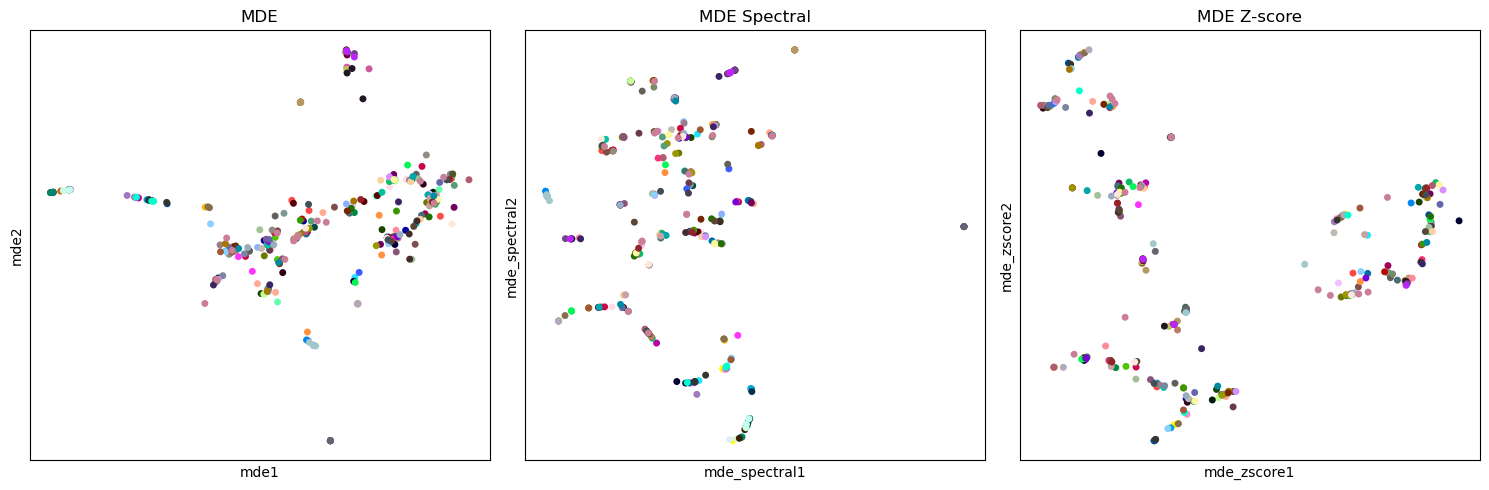

In [465]:
plt.rcParams["figure.figsize"] = (15, 5)  # Width increased to 15 to fit three 5-inch plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Plot 1: MDE
sc.pl.embedding(
    adata_mean_LS,basis="mde",color=["ligand"],
    size=100,legend_loc="none",show=False,
    ax=ax1,title="MDE"
)

# Plot 2: MDE Spectral
sc.pl.embedding(
    adata_mean_LS,basis="mde_spectral",color=["ligand"],
    size=100,legend_loc="none",show=False,
    ax=ax2,title="MDE Spectral"
)

# Plot 3: MDE Z-score
sc.pl.embedding(
    adata_mean_LS,basis="mde_zscore",color=["ligand"],
    size=100,legend_loc="none",show=False,
    ax=ax3,title="MDE Z-score"
)

plt.tight_layout()
plt.show()

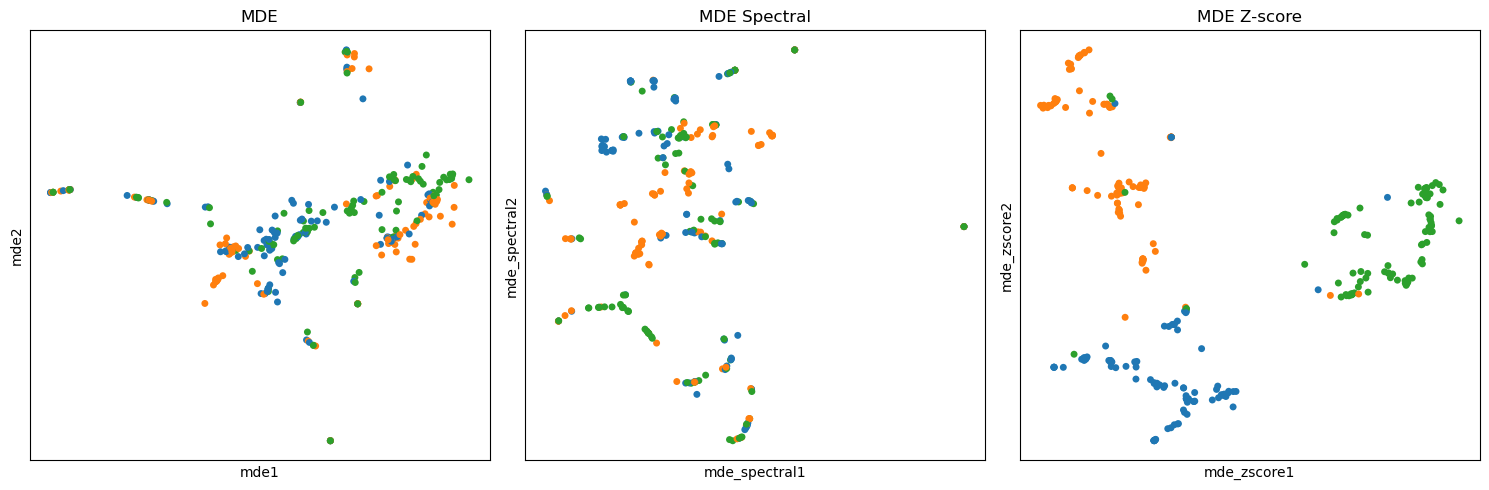

In [470]:
plt.rcParams["figure.figsize"] = (15, 5)  # Width increased to 15 to fit three 5-inch plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Plot 1: MDE
sc.pl.embedding(
    adata_mean_LS,basis="mde",color=["group"],
    size=100,legend_loc="none",show=False,
    ax=ax1,title="MDE"
)

# Plot 2: MDE Spectral
sc.pl.embedding(
    adata_mean_LS,basis="mde_spectral",color=["group"],
    size=100,legend_loc="none",show=False,
    ax=ax2,title="MDE Spectral"
)

# Plot 3: MDE Z-score
sc.pl.embedding(
    adata_mean_LS,basis="mde_zscore",color=["group"],
    size=100,legend_loc="none",show=False,
    ax=ax3,title="MDE Z-score"
)

plt.tight_layout()
plt.show()

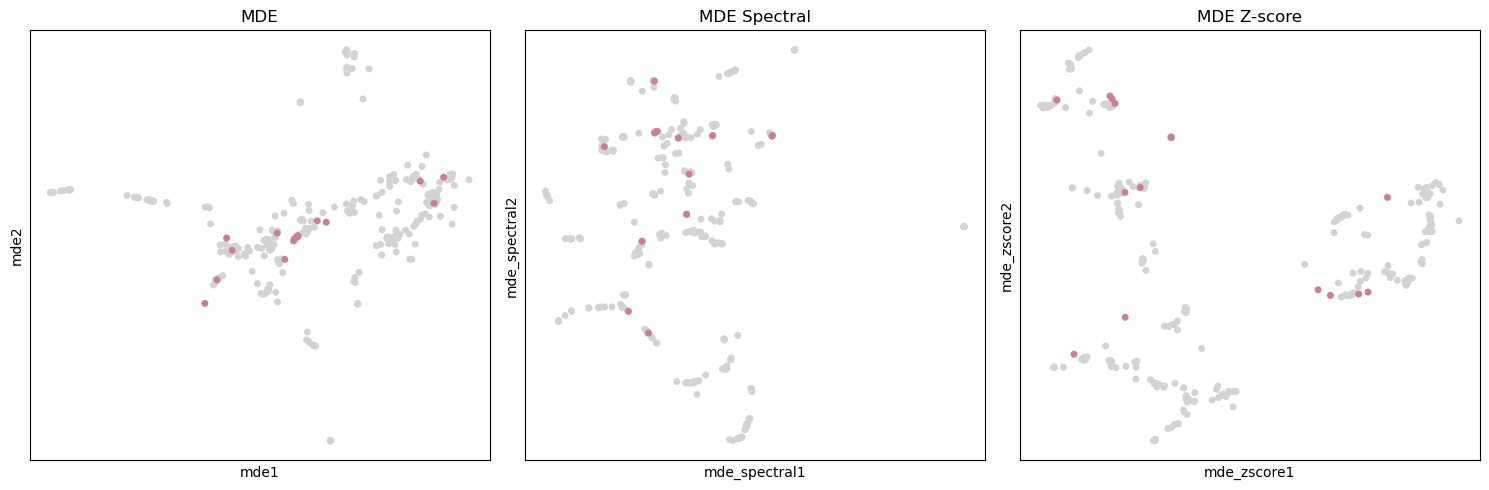

In [467]:
plt.rcParams["figure.figsize"] = (15, 5)  # Width increased to 15 to fit three 5-inch plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Plot 1: MDE
sc.pl.embedding(
    adata_mean_LS,basis="mde",color=["ligand"],groups=["linker"],
    size=100,legend_loc="none",show=False,
    ax=ax1,title="MDE"
)

# Plot 2: MDE Spectral
sc.pl.embedding(
    adata_mean_LS,basis="mde_spectral",color=["ligand"],groups=["linker"],
    size=100,legend_loc="none",show=False,
    ax=ax2,title="MDE Spectral"
)

# Plot 3: MDE Z-score
sc.pl.embedding(
    adata_mean_LS,basis="mde_zscore",color=["ligand"],groups=["linker"],
    size=100,legend_loc="none",show=False,
    ax=ax3,title="MDE Z-score"
)

plt.tight_layout()
plt.show()

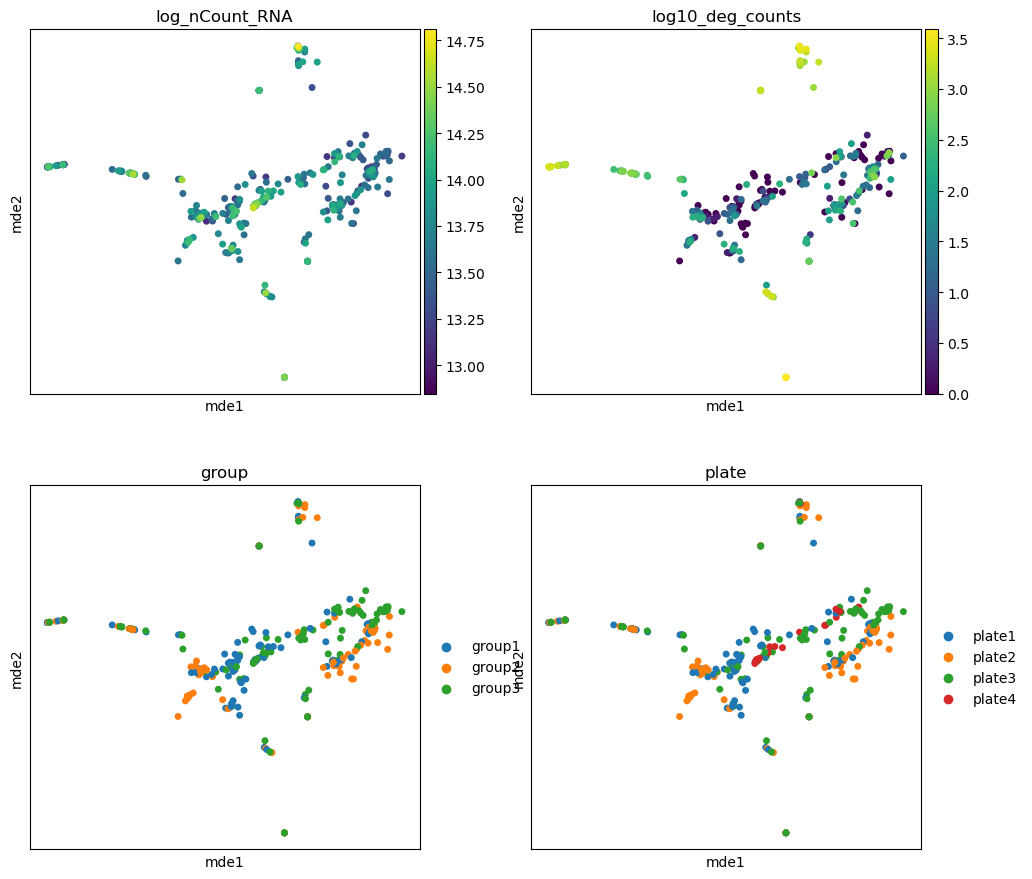

In [468]:
plt.rcParams["figure.figsize"] = (5, 5)  # Width, height in inches
sc.pl.embedding(adata_mean_LS, basis="mde",
                color=["log_nCount_RNA","log10_deg_counts","group","plate"],
                ncols=2,size=100)

# MDE at ligand level

In [542]:
# make copy of data
adataHM = adata.copy()
# remove recomb and none ligands
mask2 = ~adataHM.obs['ligand'].str.contains('recomb|none', case=False, na=False)
# apply both masks
adataHM = adataHM[mask2].copy()
# change layers
adataHM.X = adataHM.layers['log1p_norm_regressed'].copy()

# find HVGs
sc.pp.highly_variable_genes(adataHM, n_top_genes=4000)
# Remove TCR and IG genes
adataHM, matching_genes = update_highly_variable_genes(adataHM, r"^Tra[vj]|^Trb[vdj]|^Igk[vc]|^Igl[vc]|^Ighv")
print(f"Number of highly variable genes remaining: {adataHM.var['highly_variable'].sum()}")

Number of highly variable genes remaining: 4000


## MDE with counts data

In [543]:
# change layers
adataHM.X = adataHM.layers['log1p_norm_regressed'].copy()
# subset adata only on HVGs
adata_hv = adataHM[:, adataHM.var['highly_variable']]
# return adata with mean aggregated values
adata_mean_ligand = mean_aggr_adata(adata_hv, aggregate_columns=['ligand'])
adata_mean_ligand.obs = adata_mean_ligand.obs.merge(degCounts,how="left",on=["ligand"])
adata_mean_ligand.obs["ligand"] = adata_mean_ligand.obs["ligand"].astype("category")
# fill NaN values in numeric columns only
numeric_columns = ['deg_counts', 'log10_deg_counts']  # specify your numeric columns
for col in numeric_columns:
    adata_mean_ligand.obs[col] = adata_mean_ligand.obs[col].fillna(0)
# perform z-scoring by row (by cell)
zscore_counts = zscore(adata_mean_ligand.X, axis = 1)

/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [544]:
# Use pymde for high-dimensional embedding
mde = pymde.preserve_neighbors(
    zscore_counts,
    embedding_dim=2,
    repulsive_fraction=5
)
embedding = mde.embed()

# Add the embedding to the AnnData object
adata_mean_ligand.obsm["mde"] = embedding.numpy()

## MDE with z-scored counts data

In [545]:
# change layers
adataHM.X = adataHM.layers['zscore_group_regressed'].copy()
# subset adata only on HVGs
adata_hv = adataHM[:, adataHM.var['highly_variable']]
# return adata with mean aggregated values
adata_mean_temp = mean_aggr_adata(adata_hv, aggregate_columns=['ligand'])
adata_mean_temp.obs = adata_mean_temp.obs.merge(degCounts,how="left",on=["ligand"])
adata_mean_temp.obs["ligand"] = adata_mean_temp.obs["ligand"].astype("category")

# fill NaN values in numeric columns only
numeric_columns = ['deg_counts', 'log10_deg_counts']  # specify your numeric columns
for col in numeric_columns:
    adata_mean_temp.obs[col] = adata_mean_temp.obs[col].fillna(0)
    
# Create mask for non-NaN values
valid_mask = ~np.any(np.isnan(adata_mean_temp.X), axis=0) & ~np.any(np.isinf(adata_mean_temp.X), axis=0)
# Subset adata_mean_temp to keep only rows without NaN values
adata_mean_temp = adata_mean_temp[:,valid_mask]

# perform z-scoring by row (by cell)
zscore_counts = zscore(adata_mean_temp.X, axis = 1)

/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [546]:
# Use pymde for high-dimensional embedding
mde = pymde.preserve_neighbors(
    zscore_counts,
    embedding_dim=2,
    repulsive_fraction=5
)
embedding = mde.embed()

# Add the embedding to the AnnData object
adata_mean_ligand.obsm["mde_zscore"] = embedding.numpy()

## Visualization

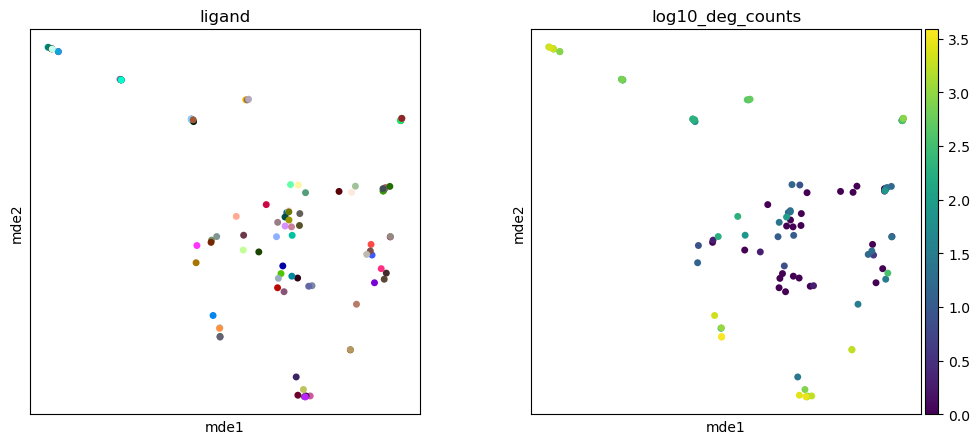

In [547]:
plt.rcParams["figure.figsize"] = (5, 5)  # Width, height in inches
sc.pl.embedding(adata_mean_ligand, basis="mde", color=["ligand","log10_deg_counts"],
                ncols=2, size=100, legend_loc="none")

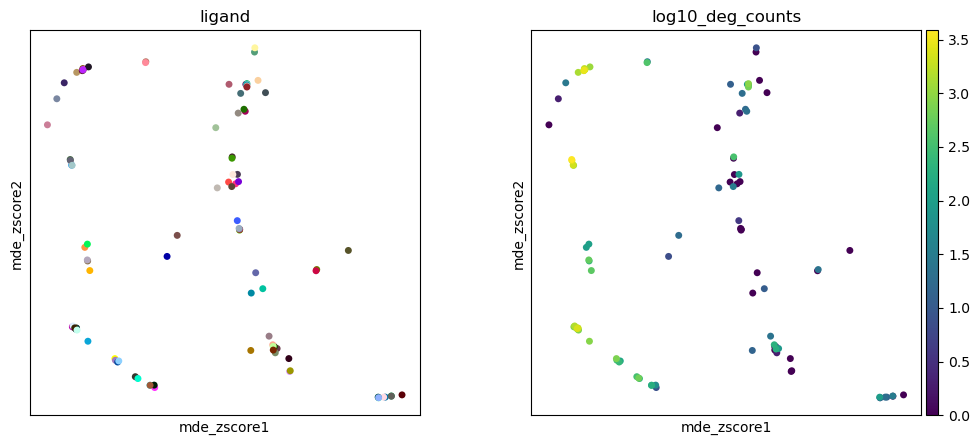

In [548]:
plt.rcParams["figure.figsize"] = (5, 5)  # Width, height in inches
sc.pl.embedding(adata_mean_ligand, basis="mde_zscore", color=["ligand","log10_deg_counts"],
                ncols=2, size=100, legend_loc="none")

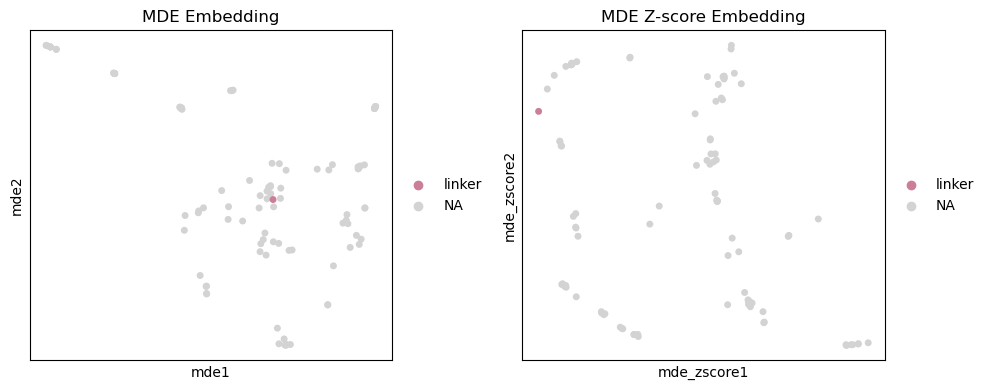

In [549]:
# Create a figure with two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# First embedding plot
sc.pl.embedding(adata_mean_ligand, basis="mde", color=["ligand"],
                groups=["linker"], size=100,
                show=False, ax=ax1, title='MDE Embedding')

# Second embedding plot
sc.pl.embedding(adata_mean_ligand, basis="mde_zscore", color=["ligand"],
                groups=["linker"], size=100,
                show=False, ax=ax2, title='MDE Z-score Embedding')

plt.tight_layout()
plt.show()

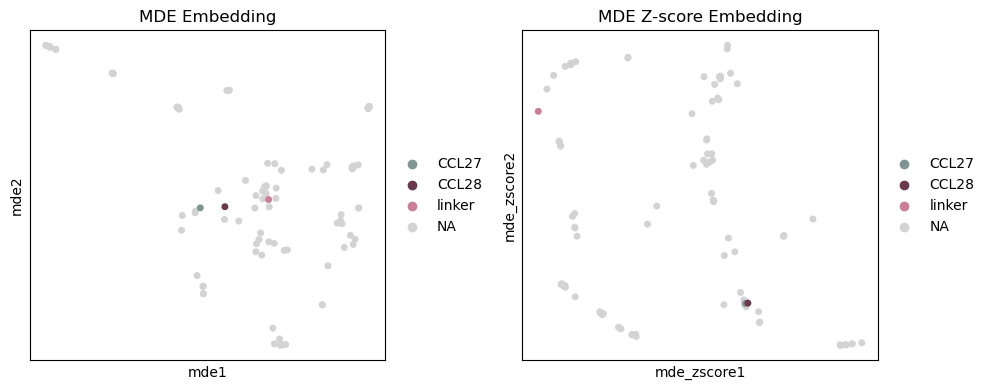

In [550]:
# Create a figure with two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# First embedding plot
sc.pl.embedding(adata_mean_ligand, basis="mde", color=["ligand"],
                groups=['CCL27','CCL28','linker'],size=100,
                show=False, ax=ax1, title='MDE Embedding')

# Second embedding plot
sc.pl.embedding(adata_mean_ligand, basis="mde_zscore", color=["ligand"],
                groups=['CCL27','CCL28','linker'],size=100,
                show=False, ax=ax2, title='MDE Z-score Embedding')

plt.tight_layout()
plt.show()

# HDBSCAN at ligand level
Using anndata objects created in 5 and 6.

In [551]:
import hdbscan

In [552]:
# make copy of data
adataHM = adata.copy()
# remove recomb and none ligands
mask2 = ~adataHM.obs['ligand'].str.contains('recomb|none', case=False, na=False)
# apply both masks
adataHM = adataHM[mask2].copy()
# change layers
adataHM.X = adataHM.layers['log1p_norm_regressed'].copy()

# find HVGs
sc.pp.highly_variable_genes(adataHM, n_top_genes=4000)
# Remove TCR and IG genes
adataHM, matching_genes = update_highly_variable_genes(adataHM, r"^Tra[vj]|^Trb[vdj]|^Igk[vc]|^Igl[vc]|^Ighv")
print(f"Number of highly variable genes remaining: {adataHM.var['highly_variable'].sum()}")

Number of highly variable genes remaining: 4000


In [553]:
adata_mean_ligand

AnnData object with n_obs × n_vars = 100 × 4000
    obs: 'ligand', 'deg_counts', 'log10_deg_counts'
    var: 'gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ligand_colors'
    obsm: 'mde', 'mde_zscore'

## Log1p normalized clustering

<Axes: ylabel='$\\lambda$ value'>

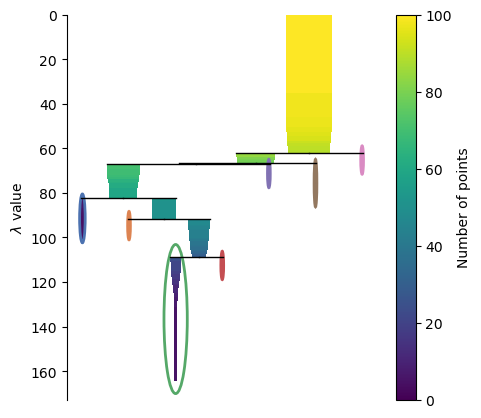

In [554]:
# Extract the data matrix for clustering (using log1p_norm layer)
X = adata_mean_ligand.X
# Initialize and run HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,
    min_samples=1,        # Adjust this parameter based on your dataset
    metric='correlation',
    cluster_selection_method='leaf'
)

# Fit and get cluster labels
clusters_log1p = clusterer.fit_predict(X)
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 12))

## Z-score normalized clustering

In [555]:
# change layers
adataHM.X = adataHM.layers['zscore_group_regressed'].copy()
# subset adata only on HVGs
adata_hv = adataHM[:, adataHM.var['highly_variable']]
# return adata with mean aggregated values
adata_mean_temp = mean_aggr_adata(adata_hv, aggregate_columns=['ligand'])
adata_mean_temp.obs = adata_mean_temp.obs.merge(degCounts,how="left",on=["ligand"])
adata_mean_temp.obs["ligand"] = adata_mean_temp.obs["ligand"].astype("category")

# fill NaN values in numeric columns only
numeric_columns = ['deg_counts', 'log10_deg_counts']  # specify your numeric columns
for col in numeric_columns:
    adata_mean_temp.obs[col] = adata_mean_temp.obs[col].fillna(0)
    
# Create mask for non-NaN values
valid_mask = ~np.any(np.isnan(adata_mean_temp.X), axis=0) & ~np.any(np.isinf(adata_mean_temp.X), axis=0)
# Subset adata_mean_temp to keep only rows without NaN values
adata_mean_temp = adata_mean_temp[:,valid_mask]

/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


<Axes: ylabel='$\\lambda$ value'>

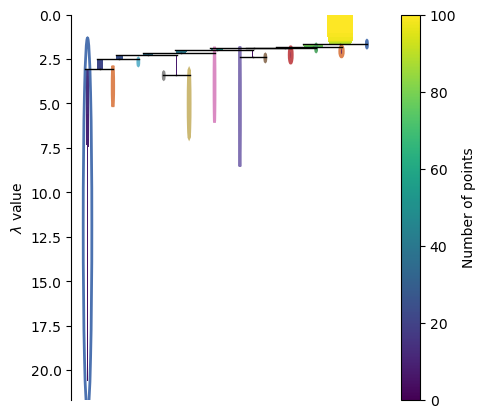

In [556]:
# Extract the data matrix for clustering
X = adata_mean_temp.X
# Initialize and run HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,        # Adjust this parameter based on your dataset
    metric='correlation'
)

# Fit and get cluster labels
clusters_zscore = clusterer.fit_predict(X)
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 12))

In [557]:
adata_mean_ligand.obs.to_csv('/data/rudensky/EYW/git_projects/SIG06/analysis_outs/hdbscan_all_ligands.csv')

## Visualization

In [558]:
# add clusters back to adata_mean_ligand
adata_mean_ligand.obs['hdbscan_zscore_clusters'] = pd.Categorical(clusters_zscore)
adata_mean_ligand.obs['hdbscan_log1p_clusters'] = pd.Categorical(clusters_log1p)

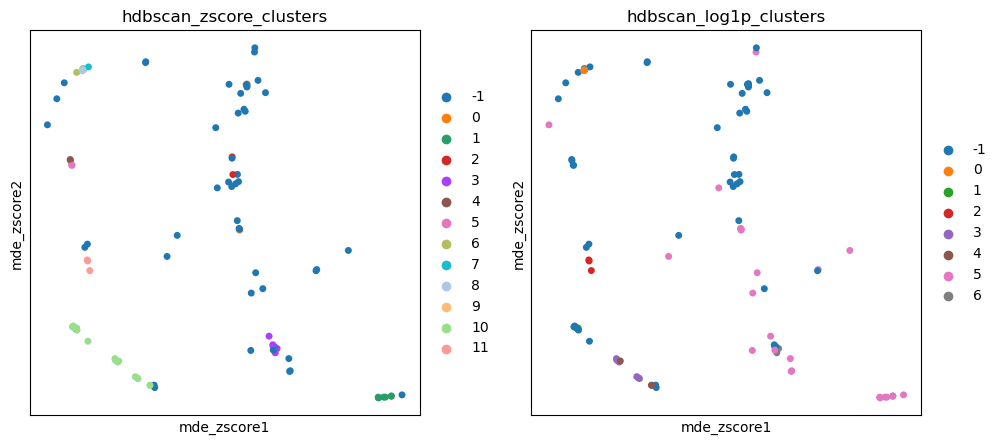

In [559]:
plt.rcParams["figure.figsize"] = (5, 5)  # Width, height in inches
sc.pl.embedding(adata_mean_ligand, basis="mde_zscore", color=['hdbscan_zscore_clusters','hdbscan_log1p_clusters'],
                ncols=2, size=100)

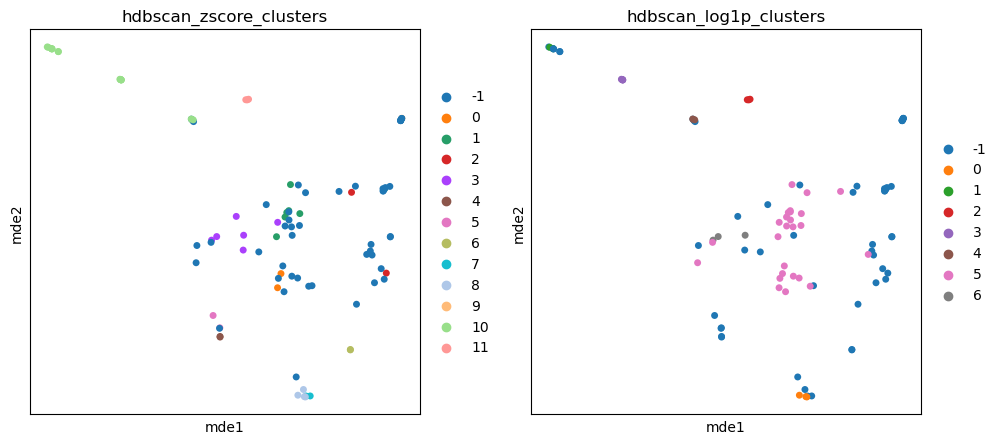

In [560]:
plt.rcParams["figure.figsize"] = (5, 5)  # Width, height in inches
sc.pl.embedding(adata_mean_ligand, basis="mde", color=['hdbscan_zscore_clusters','hdbscan_log1p_clusters'],
                ncols=2, size=100)

# MDE at ligand level DEG high ligands

In [561]:
# make copy of data
adataHM = adata.copy()

# subset deg
degCountsHigh = degCounts[degCounts["deg_counts"] > 10]

# remove recomb and none ligands
mask1 = (adataHM.obs['ligand'].isin(degCountsHigh["ligand"]))|(adataHM.obs['ligand']=="linker")
mask2 = ~adataHM.obs['ligand'].str.contains('recomb|none', case=False, na=False)
adataHM = adataHM[mask1 & mask2].copy()

# find HVGs
sc.pp.highly_variable_genes(adataHM, n_top_genes=2000)
# Remove TCR and IG genes
adataHM, matching_genes = update_highly_variable_genes(adataHM, r"^Tra[vj]|^Trb[vdj]|^Igk[vc]|^Igl[vc]|^Ighv")
print(f"Number of highly variable genes remaining: {adataHM.var['highly_variable'].sum()}")

Number of highly variable genes remaining: 2000


## MDE with counts data

In [562]:
# change layers
adataHM.X = adataHM.layers['log1p_norm_regressed'].copy()
# subset adata only on HVGs
adata_hv = adataHM[:, adataHM.var['highly_variable']]
# return adata with mean aggregated values
adata_mean_deg = mean_aggr_adata(adata_hv, aggregate_columns=['ligand'])
adata_mean_deg.obs = adata_mean_deg.obs.merge(degCounts,how="left",on=["ligand"])
adata_mean_deg.obs["ligand"] = adata_mean_deg.obs["ligand"].astype("category")
# fill NaN values in numeric columns only
numeric_columns = ['deg_counts', 'log10_deg_counts']  # specify your numeric columns
for col in numeric_columns:
    adata_mean_deg.obs[col] = adata_mean_deg.obs[col].fillna(0)
# perform z-scoring by row (by cell)
zscore_counts = zscore(adata_mean_deg.X, axis = 1)

/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [563]:
# Use pymde for high-dimensional embedding
mde = pymde.preserve_neighbors(
    zscore_counts,
    embedding_dim=2,
    repulsive_fraction=10
)
embedding = mde.embed()

# Add the embedding to the AnnData object
adata_mean_deg.obsm["mde"] = embedding.numpy()

## MDE with z-scored counts data

In [564]:
# change layers
adataHM.X = adataHM.layers['zscore_group_regressed'].copy()
# subset adata only on HVGs
adata_hv = adataHM[:, adataHM.var['highly_variable']]
# return adata with mean aggregated values
adata_mean_temp = mean_aggr_adata(adata_hv, aggregate_columns=['ligand'])
adata_mean_temp.obs = adata_mean_temp.obs.merge(degCounts,how="left",on=["ligand"])
adata_mean_temp.obs["ligand"] = adata_mean_temp.obs["ligand"].astype("category")

# fill NaN values in numeric columns only
numeric_columns = ['deg_counts', 'log10_deg_counts']  # specify your numeric columns
for col in numeric_columns:
    adata_mean_temp.obs[col] = adata_mean_temp.obs[col].fillna(0)
    
# Create mask for non-NaN values
valid_mask = ~np.any(np.isnan(adata_mean_temp.X), axis=0) & ~np.any(np.isinf(adata_mean_temp.X), axis=0)
# Subset adata_mean_temp to keep only rows without NaN values
adata_mean_temp = adata_mean_temp[:,valid_mask]

# perform z-scoring by row (by cell)
zscore_counts = zscore(adata_mean_temp.X, axis = 1)

/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [565]:
# Use pymde for high-dimensional embedding
mde = pymde.preserve_neighbors(
    zscore_counts,
    embedding_dim=2,
    repulsive_fraction=10
)
embedding = mde.embed()

# Add the embedding to the AnnData object
adata_mean_deg.obsm["mde_zscore"] = embedding.numpy()

## Visualization

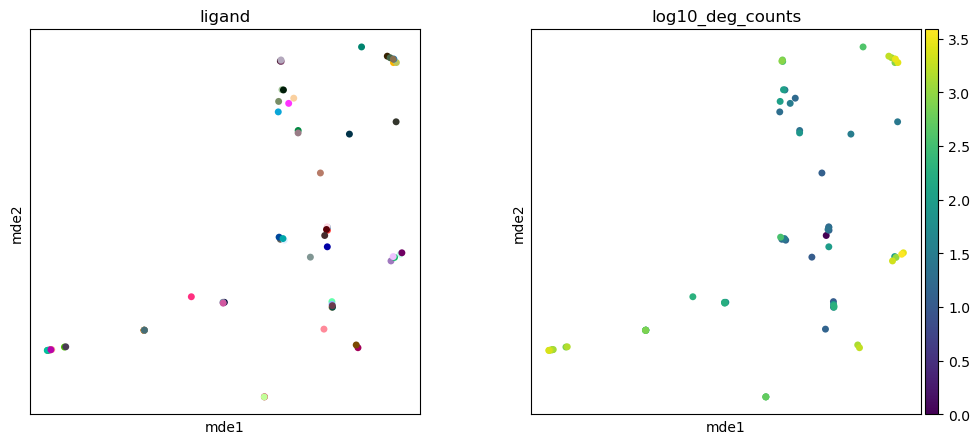

In [566]:
plt.rcParams["figure.figsize"] = (5, 5)  # Width, height in inches
sc.pl.embedding(adata_mean_deg, basis="mde", color=["ligand","log10_deg_counts"],
                ncols=2, size=100, legend_loc="none")

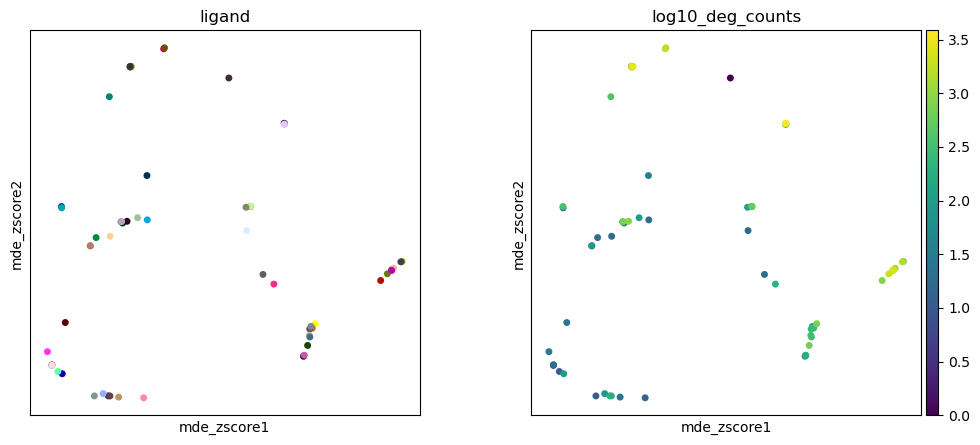

In [567]:
plt.rcParams["figure.figsize"] = (5, 5)  # Width, height in inches
sc.pl.embedding(adata_mean_deg, basis="mde_zscore", color=["ligand","log10_deg_counts"],
                ncols=2, size=100, legend_loc="none")

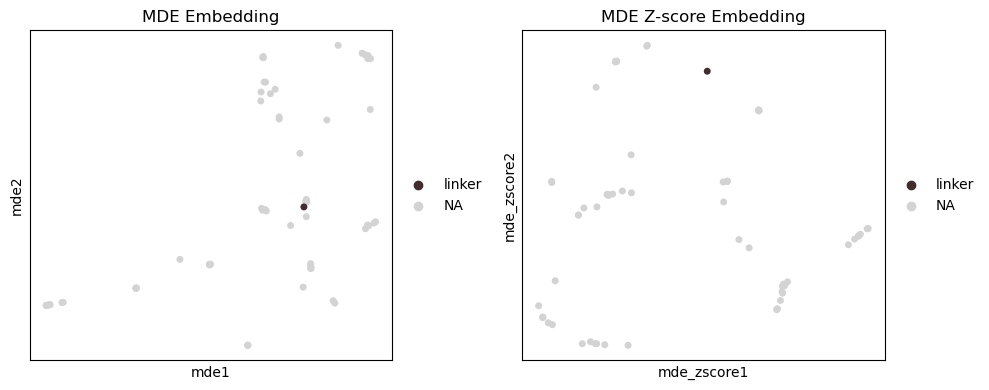

In [568]:
# Create a figure with two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# First embedding plot
sc.pl.embedding(adata_mean_deg, basis="mde", color=["ligand"],
                groups=["linker"], size=100,
                show=False, ax=ax1, title='MDE Embedding')

# Second embedding plot
sc.pl.embedding(adata_mean_deg, basis="mde_zscore", color=["ligand"],
                groups=["linker"], size=100,
                show=False, ax=ax2, title='MDE Z-score Embedding')

plt.tight_layout()
plt.show()

# HDBSCAN at ligand level DEG high ligands
Using anndata objects created in 5 and 6.

In [569]:
import hdbscan

In [570]:
adata_mean_deg

AnnData object with n_obs × n_vars = 67 × 2000
    obs: 'ligand', 'deg_counts', 'log10_deg_counts'
    var: 'gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ligand_colors'
    obsm: 'mde', 'mde_zscore'

## Log1p normalized clustering

<Axes: ylabel='$\\lambda$ value'>

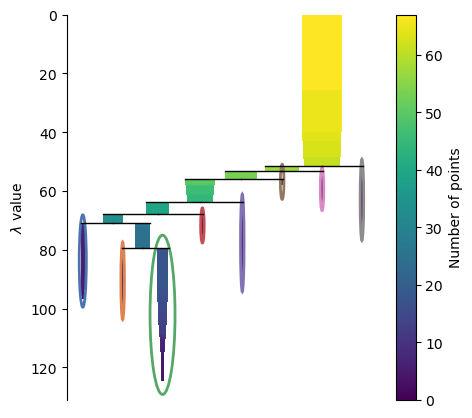

In [571]:
# Extract the data matrix for clustering (using log1p_norm layer)
X = adata_mean_deg.X
# Initialize and run HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,
    min_samples=1,        # Adjust this parameter based on your dataset
    metric='correlation',
    cluster_selection_method='leaf'
)

# Fit and get cluster labels
clusters_log1p = clusterer.fit_predict(X)
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 12))

## Z-score normalized clustering

In [572]:
# change layers
adataHM.X = adataHM.layers['zscore_group_regressed'].copy()
# subset adata only on HVGs
adata_hv = adataHM[:, adataHM.var['highly_variable']]
# return adata with mean aggregated values
adata_mean_temp = mean_aggr_adata(adata_hv, aggregate_columns=['ligand'])
adata_mean_temp.obs = adata_mean_temp.obs.merge(degCounts,how="left",on=["ligand"])
adata_mean_temp.obs["ligand"] = adata_mean_temp.obs["ligand"].astype("category")

# fill NaN values in numeric columns only
numeric_columns = ['deg_counts', 'log10_deg_counts']  # specify your numeric columns
for col in numeric_columns:
    adata_mean_temp.obs[col] = adata_mean_temp.obs[col].fillna(0)
    
# Create mask for non-NaN values
valid_mask = ~np.any(np.isnan(adata_mean_temp.X), axis=0) & ~np.any(np.isinf(adata_mean_temp.X), axis=0)
# Subset adata_mean_temp to keep only rows without NaN values
adata_mean_temp = adata_mean_temp[:,valid_mask]

/lila/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


<Axes: ylabel='$\\lambda$ value'>

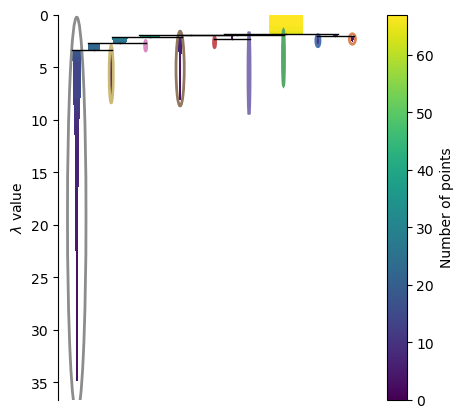

In [573]:
# Extract the data matrix for clustering
X = adata_mean_temp.X
# Initialize and run HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,        # Adjust this parameter based on your dataset
    metric='correlation'
)

# Fit and get cluster labels
clusters_zscore = clusterer.fit_predict(X)
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 12))

## Visualization

In [574]:
# add clusters back to adata_mean_ligand
adata_mean_deg.obs['hdbscan_zscore_clusters'] = pd.Categorical(clusters_zscore)
adata_mean_deg.obs['hdbscan_log1p_clusters'] = pd.Categorical(clusters_log1p)

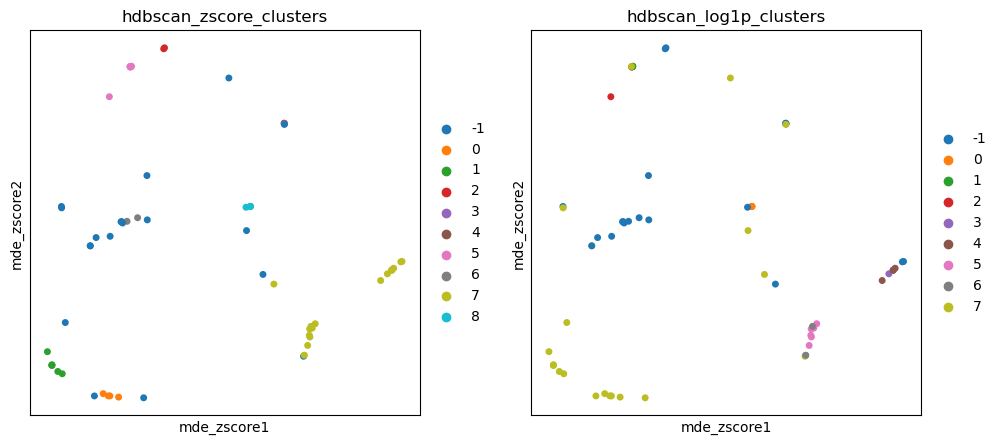

In [575]:
plt.rcParams["figure.figsize"] = (5, 5)  # Width, height in inches
sc.pl.embedding(adata_mean_deg, basis="mde_zscore", color=['hdbscan_zscore_clusters','hdbscan_log1p_clusters'],
                ncols=2, size=100)

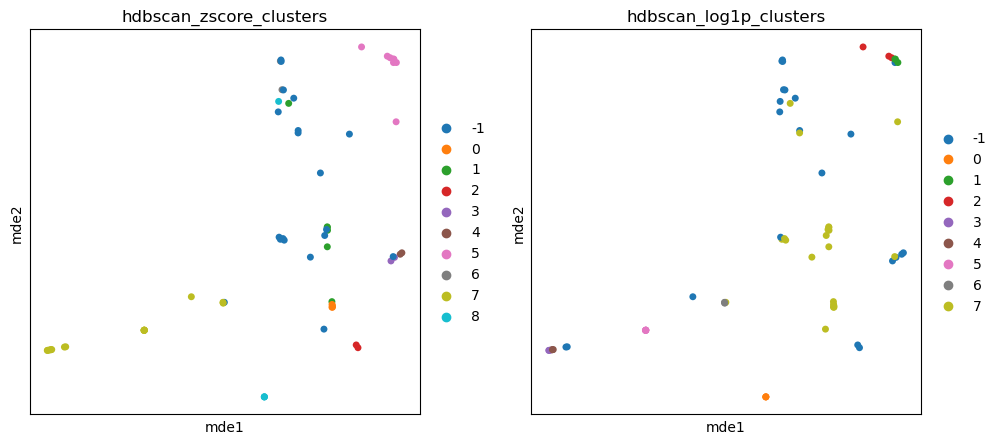

In [576]:
plt.rcParams["figure.figsize"] = (5, 5)  # Width, height in inches
sc.pl.embedding(adata_mean_deg, basis="mde", color=['hdbscan_zscore_clusters','hdbscan_log1p_clusters'],
                ncols=2, size=100)

In [577]:
adata_mean_deg.obs.to_csv('/data/rudensky/EYW/git_projects/SIG06/analysis_outs/hdbscan_deg_high.csv')